# Load (and re-load AFIM) libraries

In [1]:
import sys, os, pygmt, importlib, re, time, glob, dask, io, math
mod_path = '/home/581/da1339/AFIM/src/AFIM/src'
sys.path.insert(0, mod_path)
from sea_ice_toolbox        import SeaIceToolbox, SeaIceToolboxManager
from datetime               import timedelta, date, datetime
from pathlib                import Path
from dask.distributed       import Client, LocalCluster
from dask.diagnostics       import ProgressBar
from pyproj                 import CRS, Transformer
from collections            import defaultdict
from scipy.interpolate      import interp1d
from tqdm                   import tqdm        
import numpy                as np
import pandas               as pd
import xarray               as xr
import xesmf                as xe
import matplotlib.pyplot    as plt
import matplotlib.dates     as mdates
import matplotlib.animation as animation
from IPython.display        import Image, HTML, Video
import warnings
warnings.filterwarnings("ignore", message="Sending large graph of size", category=UserWarning, module="distributed.client")

In [ ]:
import sys
import importlib
for mod in list(sys.modules):
    if mod.startswith("sea_ice_toolbox") or mod.startswith("sea_ice_"):
        del sys.modules[mod]
import sea_ice_plotter
import sea_ice_classification
import sea_ice_icebergs
import sea_ice_observations
import sea_ice_metrics
import sea_ice_toolbox
import sea_ice_gridwork
importlib.reload(sea_ice_plotter)
importlib.reload(sea_ice_classification)
importlib.reload(sea_ice_icebergs)
importlib.reload(sea_ice_observations)
importlib.reload(sea_ice_metrics)
importlib.reload(sea_ice_toolbox)
importlib.reload(sea_ice_gridwork)
from sea_ice_toolbox import SeaIceToolbox, SeaIceToolboxManager

In [ ]:
FIA_dict    = {}
sim_name    = "elps-min"
dt0_str     = "2000-01-01"
dtN_str     = "2018-12-31"
P_log       = Path(Path.home(), "logs", "paper1_sandbox2.log")
SI_tool_mgr = SeaIceToolboxManager(P_log=P_log)
SI_tools    = SI_tool_mgr.get_toolbox(dt0_str  = dt0_str,
                                      dtN_str  = dtN_str,
                                      sim_name = sim_name)
FIA_dict['AF2020']  = {'FIA' : SI_tools.load_AF2020_FIA_summary()['FIA_obs']}
P_zarr              = Path(SI_tools.D_ispd_thresh, "FI_BT_bin_mets.zarr")
SI_tools.logger.info(f"opening zarr met file: {P_zarr}")
ds                   = xr.open_zarr(P_zarr, consolidated=False)
FIA_dict[sim_name]   = {'FIA'   : ds['FIA']}
print(FIA_dict)

In [11]:
from matplotlib.ticker import MaxNLocator

# -----------------------------
# Config
# -----------------------------
ANNUAL_AGG = "mean"  # choose: "mean", "max", or "min"
T0 = np.datetime64("2000-03-01")
T1 = np.datetime64("2018-03-01")
OUTA = "/g/data/gv90/da1339/GRAPHICAL/AFIM/elps-min/FIA_interannual_figA.png"
OUTB = "/g/data/gv90/da1339/GRAPHICAL/AFIM/elps-min/FIA_interannual_figB.png"

# -----------------------------
# 1) Extract and harmonise
# -----------------------------
D = FIA_dict  # your dict

da_obs = D["AF2020"]["FIA"]
da_sim = D["elps-min"]["FIA"]

# Harmonise coord name + dtype + sort
if "date" in da_obs.coords:
    da_obs = da_obs.rename({"date": "time"})
da_obs = da_obs.assign_coords(time=pd.to_datetime(da_obs["time"].values)).sortby("time")
da_sim = da_sim.assign_coords(time=pd.to_datetime(da_sim["time"].values)).sortby("time")

# -----------------------------
# 2) Restrict to exact window
# -----------------------------
da_obs = da_obs.sel(time=slice(T0, T1))
da_sim = da_sim.sel(time=slice(T0, T1))

# -----------------------------
# 3) Fortnightly analysis (match obs sample rate)
#    We average within 14-day bins starting at T0
# -----------------------------
# Using resample('14D') after slicing at T0 aligns both to the same bin edges
obs_14d = da_obs.resample(time="14D", label="left").mean()
sim_14d = da_sim.resample(time="14D", label="left").mean()

# Ensure the two have identical time stamps (take safe intersection)
common_times = np.intersect1d(obs_14d["time"].values, sim_14d["time"].values)
obs_14d = obs_14d.sel(time=common_times)
sim_14d = sim_14d.sel(time=common_times)

# -----------------------------
# 4) Annual metrics from fortnightly means
# -----------------------------
def annual_from_fortnight(da, agg="mean"):
    r = da.resample(time="YS")
    if agg == "mean":
        out = r.mean()
    elif agg == "max":
        out = r.max()
    elif agg == "min":
        out = r.min()
    else:
        raise ValueError("agg must be one of: mean, max, min")
    # Index by calendar year for clean plotting
    s = out.to_series()
    s.index = s.index.year
    return s

ya_obs = annual_from_fortnight(obs_14d, ANNUAL_AGG)
ya_sim = annual_from_fortnight(sim_14d, ANNUAL_AGG)

years = ya_obs.index.intersection(ya_sim.index)
if len(years) < 3:
    raise RuntimeError(
        f"Insufficient overlapping years in [{T0} → {T1}]. "
        f"Obs years={ya_obs.index.min()}–{ya_obs.index.max()}, "
        f"Sim years={ya_sim.index.min()}–{ya_sim.index.max()}."
    )

yo = ya_obs.loc[years]
ys = ya_sim.loc[years]

# Anomalies for inter-annual variability skill
yo_anom = yo - yo.mean()
ys_anom = ys - ys.mean()

# Metrics
r = float(np.corrcoef(yo_anom, ys_anom)[0, 1])
rmse_anom = float(np.sqrt(np.mean((ys_anom - yo_anom) ** 2)))
bias = float(ys.mean() - yo.mean())
sigma_ratio = float(ys_anom.std(ddof=1) / (yo_anom.std(ddof=1) + 1e-12))

# -----------------------------
# 5) Plot styles (polish)
# -----------------------------
plt.rcParams.update({
    "figure.dpi": 120,
    "savefig.dpi": 300,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.grid": True,
    "grid.alpha": 0.25,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.frameon": False,
})

unit = r"×10$^{3}$ km$^{2}$"
title_span = f"{years.min()}–{years.max()} (from 14-day means; window {str(T0)[:10]}→{str(T1)[:10]})"

# -----------------------------
# 6A) FIG A — Annual series overlay
# -----------------------------
fig, ax = plt.subplots(constrained_layout=True)
ax.plot(yo.index, yo.values, marker="o", linewidth=1.6, label="AF2020 (obs)")
ax.plot(ys.index, ys.values, marker="s", linewidth=1.6, label="elps-min (sim)")

ax.set_xlabel("Year")
ax.set_ylabel(f"Annual {ANNUAL_AGG} FIA ({unit})")
#ax.set_title(f"Circum-Antarctic FIA — Annual {ANNUAL_AGG}\n{title_span}")
ax.legend()
ax.xaxis.set_major_locator(MaxNLocator(integer=True, prune="both"))
os.makedirs(os.path.dirname(OUTA), exist_ok=True)
fig.savefig(OUTA, bbox_inches="tight")
plt.close(fig)

# -----------------------------
# 6B) FIG B — Anomaly–anomaly scatter with 1:1 and LS fit
# -----------------------------
fig, ax = plt.subplots(constrained_layout=True)

ax.scatter(yo_anom.values, ys_anom.values, s=36)

# 1:1 line
lim = 1.1 * np.max(np.abs(np.r_[yo_anom.values, ys_anom.values]))
ax.plot([-lim, lim], [-lim, lim], linestyle="--", linewidth=1.2)

# Least-squares fit line
if len(yo_anom) >= 2:
    m, b = np.polyfit(yo_anom.values, ys_anom.values, 1)
    xfit = np.linspace(-lim, lim, 100)
    ax.plot(xfit, m * xfit + b, linewidth=1.2)

ax.set_xlim(-100,100)#-lim, lim)
ax.set_ylim(-100,100)#-lim, lim)
ax.set_aspect("equal", adjustable="box")

ax.set_xlabel(f"Obs anomaly ({unit})")
ax.set_ylabel(f"Sim anomaly ({unit})")
#ax.set_title(f"Inter-annual variability skill (annual anomalies)\n"
#             f"r={r:.2f}, σ$_{{sim}}$/σ$_{{obs}}$={sigma_ratio:.2f}, RMSE={rmse_anom:.1f} {unit}")

# Small metrics box for quick reading
#txt = (f"r = {r:.2f}\n"
#       f"σ_sim/σ_obs = {sigma_ratio:.2f}\n"
#       f"RMSE = {rmse_anom:.1f} {unit}\n"
#       f"Bias = {bias:.1f} {unit}")
#ax.text(0.02, 0.98, txt, transform=ax.transAxes, va="top", ha="left",
#        fontsize=9, bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="0.7", alpha=0.9))

fig.savefig(OUTB, bbox_inches="tight")
plt.close(fig)

print({
    "overlap_years": (int(years.min()), int(years.max())),
    "N_years": int(len(years)),
    "agg": ANNUAL_AGG,
    "corr_anom_r": r,
    "r2": r**2,
    "rmse_anom": rmse_anom,
    "bias_mean": bias,
    "sigma_ratio": sigma_ratio,
    "obs_mean": float(yo.mean()),
    "sim_mean": float(ys.mean()),
})
print(f"Saved: {OUTA}")
print(f"Saved: {OUTB}")



{'overlap_years': (2000, 2018), 'N_years': 19, 'agg': 'mean', 'corr_anom_r': 0.8391616003335335, 'r2': 0.704192191474337, 'rmse_anom': 31.790704866503148, 'bias_mean': 33.42257466951304, 'sigma_ratio': 0.5430854151412118, 'obs_mean': 442.45813211759634, 'sim_mean': 475.8807067871094}
Saved: /g/data/gv90/da1339/GRAPHICAL/AFIM/elps-min/FIA_interannual_figA.png
Saved: /g/data/gv90/da1339/GRAPHICAL/AFIM/elps-min/FIA_interannual_figB.png


# APPENDIX: Grounded Icebergs

In [ ]:
sim_name    = "elps-min"
dt0_str     = "1994-01-01"
dtN_str     = "1999-12-31"
P_log       = Path(Path.home(), "logs", "paper1_sandbox2.log")
SI_tool_mgr = SeaIceToolboxManager(P_log=P_log)
SI_tools    = SI_tool_mgr.get_toolbox(dt0_str  = dt0_str,
                                      dtN_str  = dtN_str,
                                      sim_name = sim_name)
SI_tools.process_raw_grounded_iceberg_database()

In [74]:
lon       = SI_tools.normalise_longitudes(SI_tools.G_t["lon"].values)
lat       = SI_tools.G_t["lat"].values
GI_cnts   = SI_tools.GI_cnts.values.astype(float)
mask      = (GI_cnts > 0) & np.isfinite(lon) & np.isfinite(lat) & (lat < -55)
print(np.shape(mask))
lon  = lon[mask]#.ravel()
lat  = lat[mask]#.ravel()
GI   = GI_cnts[mask]#.ravel()
print(np.shape(GI_cnts))
print(mask/GI_cnts)

(1080, 1440)
(1080, 1440)
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


/jobfs/151311047.gadi-pbs/ipykernel_54269/3475192706.py:10: RuntimeWarning: invalid value encountered in divide
  print(mask/GI_cnts)


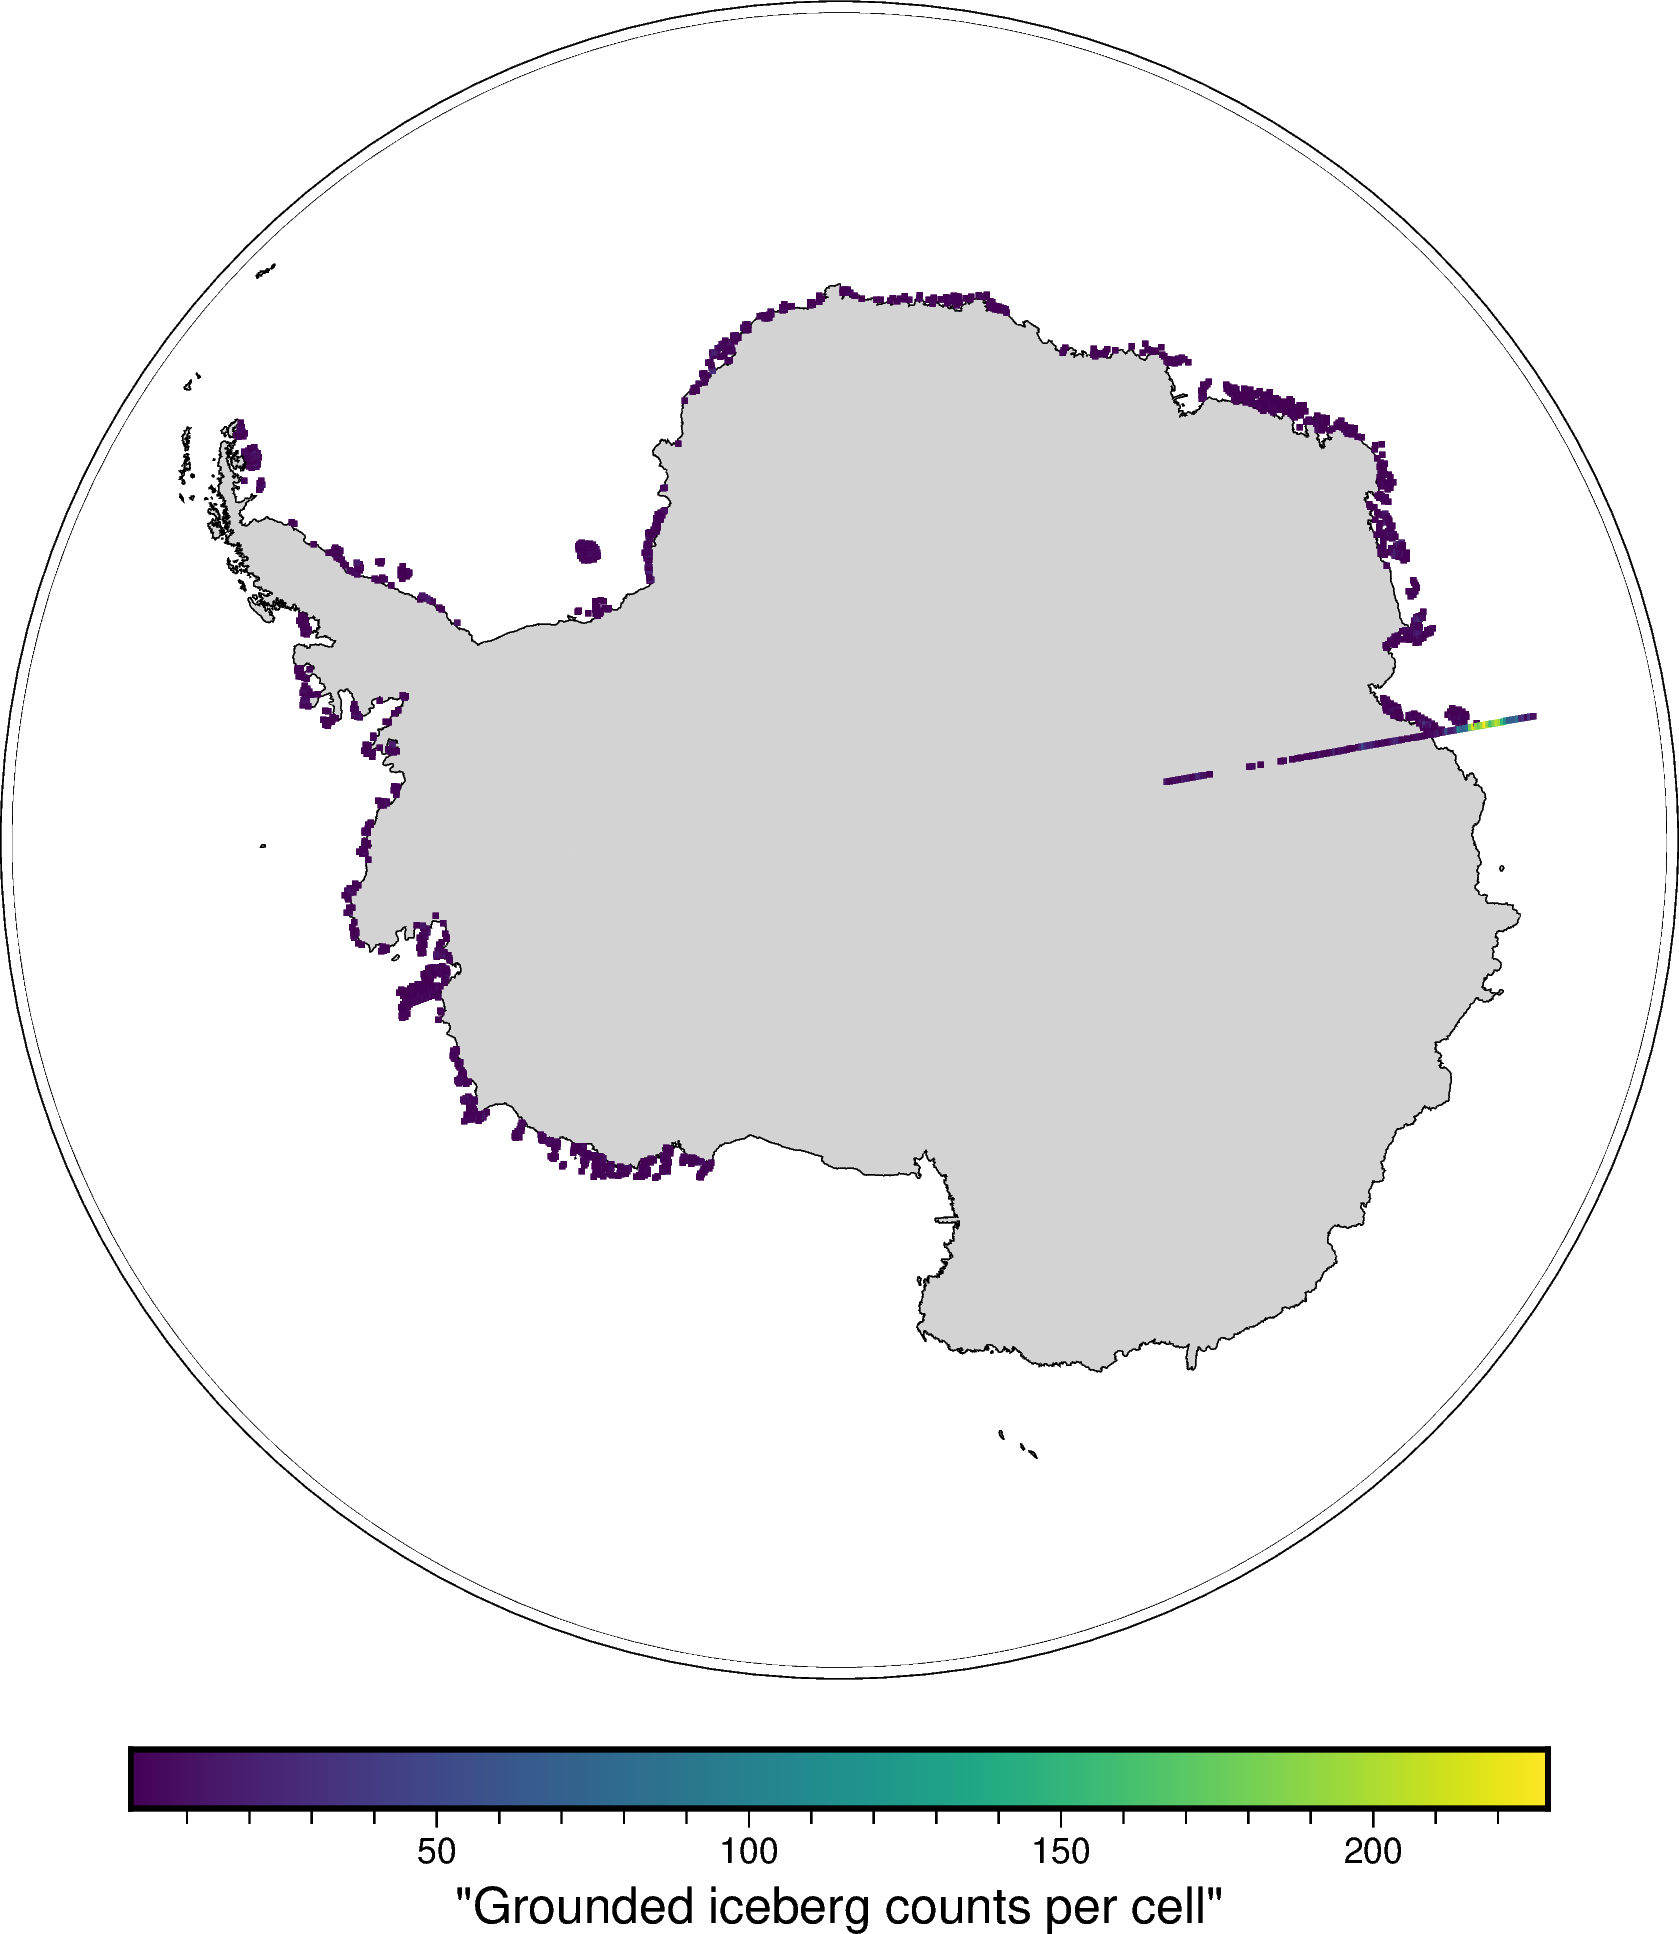

In [59]:
fig = pygmt.Figure()
fig.basemap(region=[-180,180,-90,-60], projection="S0/-90/14c", frame="g")
fig.coast(shorelines="0.25p,black", land="lightgray", water="white", resolution="i")
pygmt.makecpt(cmap="viridis", series=[1, 228])
fig.plot(x=lon_flat, y=lat_flat, style="s0.07c", fill=GI_cnts, cmap=True)
fig.colorbar(position="JBC+w12c/0.5c+o0/0.7c", frame='af+l"Grounded iceberg counts per cell"')
fig.show()

# Appendix Section: Fast Ice Classification Method Comparison

In [ ]:
files = sorted(glob.glob("/scratch/gv90/da1339/afim/methods_comp/elps-min/*.csv"))
CSV_GLOB = "/scratch/gv90/da1339/afim/methods_comp/elps-min/*.csv"
P_png = Path.home() / "graphical/AFIM/elps-min/FIA_pareto_bin_vs_roll_1994-1999_pygmt.png"

# --- Load & concat CSVs robustly (some files repeat headers) ---
dfs = []
for f in sorted(glob.glob(CSV_GLOB)):
    with open(f, "r") as fh:
        text = fh.read()
    chunks = [c for c in text.split("label,Bias,MAE,RMSE,SD_Model,Corr,SD_Obs,FIPSI,FIPmax") if c.strip()]
    for c in chunks:
        block = "label,Bias,MAE,RMSE,SD_Model,Corr,SD_Obs,FIPSI,FIPmax" + c
        dfs.append(pd.read_csv(io.StringIO(block)))
df = pd.concat(dfs, ignore_index=True)

# --- Parse label -> method, W, N ---
def parse_label(s):
    method = "bindays" if "bindays" in s else ("rollmean" if "rollmean" in s else "unknown")
    W = int(re.search(r"win(\d+)", s).group(1))
    mN = re.search(r"min(\d+)", s)
    N = int(mN.group(1)) if mN else np.nan
    return method, W, N

df[["method","W","N"]] = df["label"].apply(parse_label).apply(pd.Series)
df["abs_bias"] = df["Bias"].abs()

# --- Pareto frontier on (RMSE↓, 1-Corr↓, |Bias|↓) ---
A = np.c_[df["RMSE"].values, 1.0 - df["Corr"].values, df["abs_bias"].values]
dom = np.zeros(len(A), dtype=bool)
for i in range(len(A)):
    if dom[i]:
        continue
    for j in range(len(A)):
        if i == j:
            continue
        if np.all(A[j] <= A[i]) and np.any(A[j] < A[i]):
            dom[i] = True
            break
df["pareto"] = ~dom

# --- Short labels for sparse annotation ---
def short(row):
    if row["method"]=="bindays" and not math.isnan(row["N"]):
        return f"B W{int(row['W'])}/N{int(row['N'])}"
    if row["method"]=="rollmean":
        return f"R W{int(row['W'])}"
    return row["label"]
df["short"] = df.apply(short, axis=1)

# Annotate only: all Pareto + (B W10/N8, B W11/N9, B W12/N10, R W11)
want = df["pareto"].copy()
for tup in [("bindays",10,8),("bindays",11,9),("bindays",12,10)]:
    want |= (df["method"].eq(tup[0]) & df["W"].eq(tup[1]) & df["N"].eq(tup[2]))
want |= (df["method"].eq("rollmean") & df["W"].eq(11))

# --- Plot with PyGMT ---
fig = pygmt.Figure()
x = df["RMSE"].to_numpy()
y = df["Corr"].to_numpy()
size = 0.045 + 0.0012*df["abs_bias"].to_numpy()  # inches; tweak to taste

xmin, xmax = float(x.min())-5, float(x.max())+5
ymin, ymax = max(0, float(y.min())-0.05), min(1.0, float(y.max())+0.05)
fig.basemap(region=[xmin,130,0.5,ymax], projection="X12c/8c",
            frame=["WSne", "xaf+lRMSE", "yaf+lCorrelation"])

# rolling-mean (squares)
mask = df["method"].eq("rollmean")
fig.plot(x=x[mask], y=y[mask], style="s", size=size[mask]+0.2, pen="0.1p,black", fill="#DEC24E")

# binary-days (circles)
mask = df["method"].eq("bindays")
fig.plot(x=x[mask], y=y[mask], style="c", size=size[mask]+0.2, pen="0.1p,black", fill="#5596E0")

# Pareto ring (thicker outline)
# mask = df["pareto"].to_numpy()
# fig.plot(x=x[mask], y=y[mask], style="c", size=size[mask]+0.02, pen="0.8p,black")

# Sparse annotations
for _, r in df[want].iterrows():
    fig.text(text=r["short"], x=float(r["RMSE"]), y=float(r["Corr"]),
             font="8p,Helvetica,black", offset="0.12c/0.12c", justify="LM")

# Ticks/grid refinement
fig.basemap(frame=["xa20f10", "ya0.1f0.02"])

# Legend stubs (optional)
#fig.legend(position="JBL+jBL+o0.3c", box="+gwhite+p0.25p")
fig.show()
fig.savefig(P_png, dpi=300)
print("Wrote FIA_pareto_bin_vs_roll_1994-1999_pygmt.png")

# APPENDIX SECTION: Justification for Binary-days

## Which is the best method for computing fast ice: binary-day or rolling-mean?

+ create a dictionary of circumpolar fast ice area time series for one simulation (``elps-min``) for a range of different ``binary-day`` and ``rolling-mean`` configurations
+ calculate relevant statistical skills for each configuration against fast ice area observations (``F2020``)
+ come up with a metric (normalisation-score) for determining the best performing configuration

## How to run the cells in this section:

+ the first cell is meant to provide the rationale for why the comparison should be done (it does assume that the user knows the ``F2020`` fortnightly-climatological "shape" of the plot)
+ the second cell below runs the main analysis script in a small test case

However, to run the main analysis script as intended (to regenerate the figure results) then:
```
cd ~/AFIM/src/AFIM/scripts/classification/
qsub -J 7-16 FI_classify_methods_comparison.pbs
qsub -J 17-20 FI_classify_methods_comparison.pbs
qsub -J 1 -v MERGE=1 -W ./FI_classify_methods_comparison.pbs
```

Batch jobs can be monitored using:
```
qstat -t NNNNNNNNNN[].gadi-pbs
```

In [ ]:
FIA_dict    = {}
vars_load   = ['aice','tarea','hi']
sim_name    = "elps-min"
dt0_str     = "1994-01-01"
dtN_str     = "1994-12-31"
P_log       = Path(Path.home(), "logs", "paper1_sandbox.log")
SI_tool_mgr = SeaIceToolboxManager(P_log=P_log)
SI_tools    = SI_tool_mgr.get_toolbox(sim_name = sim_name,
                                      dt0_str  = dt0_str,
                                      dtN_str  = dtN_str,
                                      ice_speed_threshold = 5e-4)
_, FI_bin_dsA, FI_roll_ds = SI_tools.classify_fast_ice(bin_win_days         = 7,
                                                      bin_min_days          = 5,
                                                      enable_rolling_output = True,
                                                      roll_win_days         = 7)
_, FI_bin_dsB, FI_roll_ds = SI_tools.classify_fast_ice(bin_win_days         = 7,
                                                      bin_min_days          = 7,
                                                      enable_rolling_output = True,
                                                      roll_win_days         = 7)
CICE_SO       = SI_tools.load_cice_zarr(slice_hem=True, variables=['aice','tarea'], dt0_str = "1994-01-01", dtN_str = "1994-12-31",)
FI_bin_maskA  = FI_bin_dsA["FI_mask"] > 0
FI_bin_maskB  = FI_bin_dsB["FI_mask"] > 0
FI_roll_mask  = FI_roll_ds["FI_mask"] > 0 
# 1) Compute masks locally so no graph is serialized
with dask.config.set(scheduler="single-threaded"):
    FI_bin_maskA_c = FI_bin_dsA["FI_mask"].astype("bool").compute()
    FI_bin_maskB_c = FI_bin_dsB["FI_mask"].astype("bool").compute()
    FI_roll_mask_c = FI_roll_ds["FI_mask"].astype("bool").compute()
# 2) Now do the masking and area with local compute as well (or re-chunk afterwards)
with dask.config.set(scheduler="single-threaded"):
    aice_binA  = CICE_SO["aice"].where(FI_bin_maskA_c).compute()
    area_binA  = CICE_SO["tarea"].where(FI_bin_maskA_c).compute()
    aice_binB  = CICE_SO["aice"].where(FI_bin_maskB_c).compute()
    area_binB  = CICE_SO["tarea"].where(FI_bin_maskB_c).compute()
    aice_roll  = CICE_SO["aice"].where(FI_roll_mask_c).compute()
    area_roll  = CICE_SO["tarea"].where(FI_roll_mask_c).compute()
spat = SI_tools.CICE_dict["spatial_dims"]
FIA_binA = (aice_binA * area_binA).sum(dim=spat).rename("FIA")/1e9
FIA_binB = (aice_binB * area_binB).sum(dim=spat).rename("FIA")/1e9
FIA_roll = (aice_roll * area_roll).sum(dim=spat).rename("FIA")/1e9
plt.rcParams['font.family'] = 'Courier New'
fig, ax = plt.subplots(figsize=(9,4))
# overlay on same axis with distinct styles
FIA_binA.plot(ax=ax, label=r'bin-days  : 5/7-days', color='tab:blue'  , linewidth=1.8)
FIA_binB.plot(ax=ax, label=r'bin-days  : 7/7-days', color='tab:orange', linewidth=1.8)
FIA_roll.plot(ax=ax, label=r'roll-mean : 7-days'  , color='tab:green' , linewidth=1.8)
ax.set_title('FIA classification method comparison')
ax.set_ylabel('FIA (10^3 km^2)')
ax.grid(True, alpha=0.3)
ax.legend(loc='best')
plt.tight_layout()

In [ ]:
from pathlib import Path
import os, getpass, subprocess

WIN       = 9
CNT_SPAN  = 3
SIM_NAME  = "elps-min"
DT0       = "1994-01-01"
DTN       = "1995-12-31"
ISPD_THR  = "5e-4"

USER   = getpass.getuser()
OUTDIR = Path(f"/scratch/gv90/{USER}/afim/methods_comp/elps-min_test")
OUTDIR.mkdir(parents=True, exist_ok=True)
os.environ["DASK_TEMPORARY_DIRECTORY"] = str(OUTDIR / "dask-tmp")
Path(os.environ["DASK_TEMPORARY_DIRECTORY"]).mkdir(parents=True, exist_ok=True)

SCRIPT = str(Path.home() / "AFIM/src/AFIM/scripts/classification/FI_classify_methods_comparison.py")
cmd    = ["python", "-u", SCRIPT, 
          "--sim-name", SIM_NAME,
           "--dt0", DT0, 
           "--dtN", DTN,
           "--ispd", ISPD_THR,
           "--win", str(WIN),
           "--min-days-span", str(CNT_SPAN),
           "--out-dir", str(OUTDIR),]
print("Running:", " ".join(cmd))
res = subprocess.run(cmd)
if res.returncode != 0:
    raise RuntimeError(f"Driver exited with code {res.returncode}")

print("Wrote:", OUTDIR / f"metrics_win{WIN:02d}.csv")

# APPENDIX SECTION: Justification for Ice Speed Threshold

In [ ]:
SIM        = "elps-min"
ARCH       = Path("/home/581/da1339/AFIM_archive") / SIM / "zarr"
MET_BIN    = "FI_BT_bin_mets.zarr"
MET_ROLL   = "FI_BT_roll_mets.zarr" 
VAR_MAX    = "FIA_Maximum Mean"
VAR_MIN    = "FIA_Minimum Mean"
T_LIST     = [1.0e-6, 3.0e-6, 5.0e-6, 7.0e-6, 9.0e-6,
              1.0e-5, 3.0e-5, 5.0e-5, 7.0e-5, 9.0e-5,
              1.0e-4, 3.0e-4, 5.0e-4, 7.0e-4, 9.0e-4,
              1.0e-3, 3.0e-3, 5.0e-3, 7.0e-3, 9.0e-3,
              1.0e-2, 3.0e-2, 5.0e-2, 7.0e-2, 9.0e-2]
OBS_MIN    = 221
OBS_MAX    = 601
BETA_MAIN  = 5.0e-4
BETA_ANNOT = None
YMIN, YMAX = 60, 1000
OUTPNG     = Path.home() / "graphical/AFIM" / SIM / "ispd-thresh_vs_FIA-min-max_pygmt.png"
DEBUG_LIST_FIRST = True  # set False to silence var listing

In [ ]:
# --------------------------------
def find_threshold_dirs(arch_root: Path, metric_dirname: str):
    """Return sorted list of (t_value, metric_path) that actually exist."""
    dirs = []
    for p in arch_root.glob("ispd_thresh_*"):
        m = re.search(r"ispd_thresh_([0-9.]+e[+-]?\d+)", p.name)
        if not m:
            continue
        t = float(m.group(1))
        metric_path = p / metric_dirname
        if metric_path.is_dir():
            dirs.append((t, metric_path))
    # sort by threshold
    dirs.sort(key=lambda x: x[0])
    return dirs

def read_scalar_component(metric_path: Path, varname: str) -> float:
    """
    Read a scalar metric when the layout is:
      <...>/<metric>.zarr/<varname>/
    and <varname> is a *Zarr array store* (has .zarray, .zattrs, chunk files).
    """
    comp = metric_path / varname
    if not comp.is_dir():
        raise FileNotFoundError(f"Missing variable dir: {comp}")
    arr = zarr.open(zarr.DirectoryStore(str(comp)), mode="r")   # <-- Zarr array
    return float(np.array(arr)[...].ravel()[0])

def read_scalar_any(metric_path: Path, varname: str) -> float:
    """
    First try opening the metric root as an xarray Dataset (vars with spaces work),
    else fall back to reading the component as a raw Zarr array.
    """
    try:
        ds = xr.open_zarr(metric_path, consolidated=False)
        return float(np.array(ds[varname]).ravel()[0])
    except Exception:
        return read_scalar_component(metric_path, varname)

def collect_series(arch_root: Path, metric_dirname: str):
    t_vals, v_max, v_min, fails = [], [], [], []
    for t, mpath in find_threshold_dirs(arch_root, metric_dirname):
        try:
            vmax = read_scalar_any(mpath, VAR_MAX)
            vmin = read_scalar_any(mpath, VAR_MIN)
            t_vals.append(t); v_max.append(vmax); v_min.append(vmin)
        except Exception as e:
            fails.append((t, str(e).splitlines()[0]))
    return (np.array(t_vals), np.array(v_max), np.array(v_min), fails)

In [ ]:
t_bin, max_bin, min_bin, fail_bin = collect_series(ARCH, MET_BIN)
t_roll = max_roll = min_roll = np.array([])
fail_roll = []
if MET_ROLL:
    t_roll, max_roll, min_roll, fail_roll = collect_series(ARCH, MET_ROLL)
if t_bin.size == 0 and t_roll.size == 0:
    msg = ["No data read. Sample failures:"]
    msg += [f"  BIN  t={t:.1e}: {r}" for t, r in fail_bin[:5]]
    msg += [f"  ROLL t={t:.1e}: {r}" for t, r in fail_roll[:5]]
    raise RuntimeError("\n".join(msg))

In [ ]:
fig        = pygmt.Figure()
x_all      = np.r_[t_bin, t_roll] if t_roll.size else t_bin
xmin, xmax = float(x_all.min()), float(x_all.max())
fig.basemap(region     = [0, 0.001, YMIN, 800], 
            projection = "X16c/10c",
            frame      = ['WSen',
                          'xaf+l@[\\mathrm{Ice}\\ \\mathrm{Speed}\\ \\mathrm{Threshold}\\ (m/s)@[',
                          'yaf+l@[\\mathrm{Fast}\\ \\mathrm{Ice}\\ \\mathrm{Area}\\ (1\\times10^3-\\mathrm{km}^2)@['])
# AF2020 bounds
fig.plot(x=[xmin, xmax], y=[OBS_MIN, OBS_MIN], pen="1p,black,4_2:2p")
fig.plot(x=[xmin, xmax], y=[OBS_MAX, OBS_MAX], pen="1p,black,4_2:2p")
# binary-day
if t_bin.size:
    fig.plot(x=t_bin, y=min_bin, pen="1.5p,royalblue", label="@[\\mathcal{M}_{\\matchrm{FI}\\_\\mathrm{bin}}\\ \\textsc{(FIA-min)}@[")
    fig.plot(x=t_bin, y=max_bin, pen="1.5p,gold",      label="@[\\mathcal{M}_{\\matchrm{FI}\\_\\matchrm{bin}}\\ \\textsc{(FIA-max)}@[")
# rolling
if t_roll.size:
    fig.plot(x=t_roll, y=min_roll, pen="1.5p,forestgreen", label="@[\\mathcal{M}_{\\matchrm{FI}\\_\\matchrm{roll}}\\ \\textsc{(FIA-min)}@[")
    fig.plot(x=t_roll, y=max_roll, pen="1.5p,red",         label="@[\\mathcal{M}_{\\matchrm{FI}\\_\\matchrm{roll}}\\ \\textsc{(FIA-max)}@[")
# verticals
fig.plot(x=[4.0e-4,4.0e-4], y=[500, 700], pen="1p,gold,-")
fig.plot(x=[1.9e-4,1.9e-4], y=[100, 300], pen="1p,royalblue,-")
fig.plot(x=[3.4e-4,3.4e-4], y=[100, 300], pen="1p,forestgreen,-")
fig.plot(x=[6.5e-4,6.5e-4], y=[500, 700], pen="1p,red,-")
fig.plot(x=[5.0e-4,5.0e-4], y=[60, 800], pen="1p,grey,-")          #JF (default)
fig.legend(position="JTL+jTL+o0.4c/0.4c+w4.5c", box="+gwhite+p0.5p", transparency=10)
fig.show()
fig.savefig(OUTPNG, dpi=300)
print(f"Wrote {OUTPNG}")

# Parameter Modifications to Support Antarctic Fast Ice Growth (FIA_FIP panels)

2025-09-30 14:24:50,965 - INFO - log file connected: /home/581/da1339/logs/paper1_sandbox2.log
2025-09-30 14:24:50,972 - INFO - Dask Client Connected
  Dashboard      : /proxy/8787/status
  Threads        : 4
  Threads/Worker : [1, 1, 1, 1]
  Total Memory   : 64.00 GB

2025-09-30 14:24:50,973 - INFO - hemisphere initialised: SH
2025-09-30 14:24:50,975 - INFO - reading /g/data/gv90/da1339/afim_output/elps-min/ice_diag.d to construct /g/data/gv90/da1339/afim_output/elps-min/ice_in_AFIM_subset_elps-min.json
2025-09-30 14:24:50,996 - INFO -  self.ice_class defined as FI_BT
2025-09-30 14:24:50,998 - INFO - --- SeaIceToolbox Summary ---
2025-09-30 14:24:50,999 - INFO - Simulation Name     : elps-min
2025-09-30 14:24:51,000 - INFO - Analysis Start Date : 1994-01-01
2025-09-30 14:24:51,001 - INFO - Analysis End Date   : 1999-12-31
2025-09-30 14:24:51,002 - INFO - Speed Threshold     : 5.0e-04 m/s
2025-09-30 14:24:51,004 - INFO - Speed Type(s)       : BT
2025-09-30 14:24:51,005 - INFO - Ice Typ

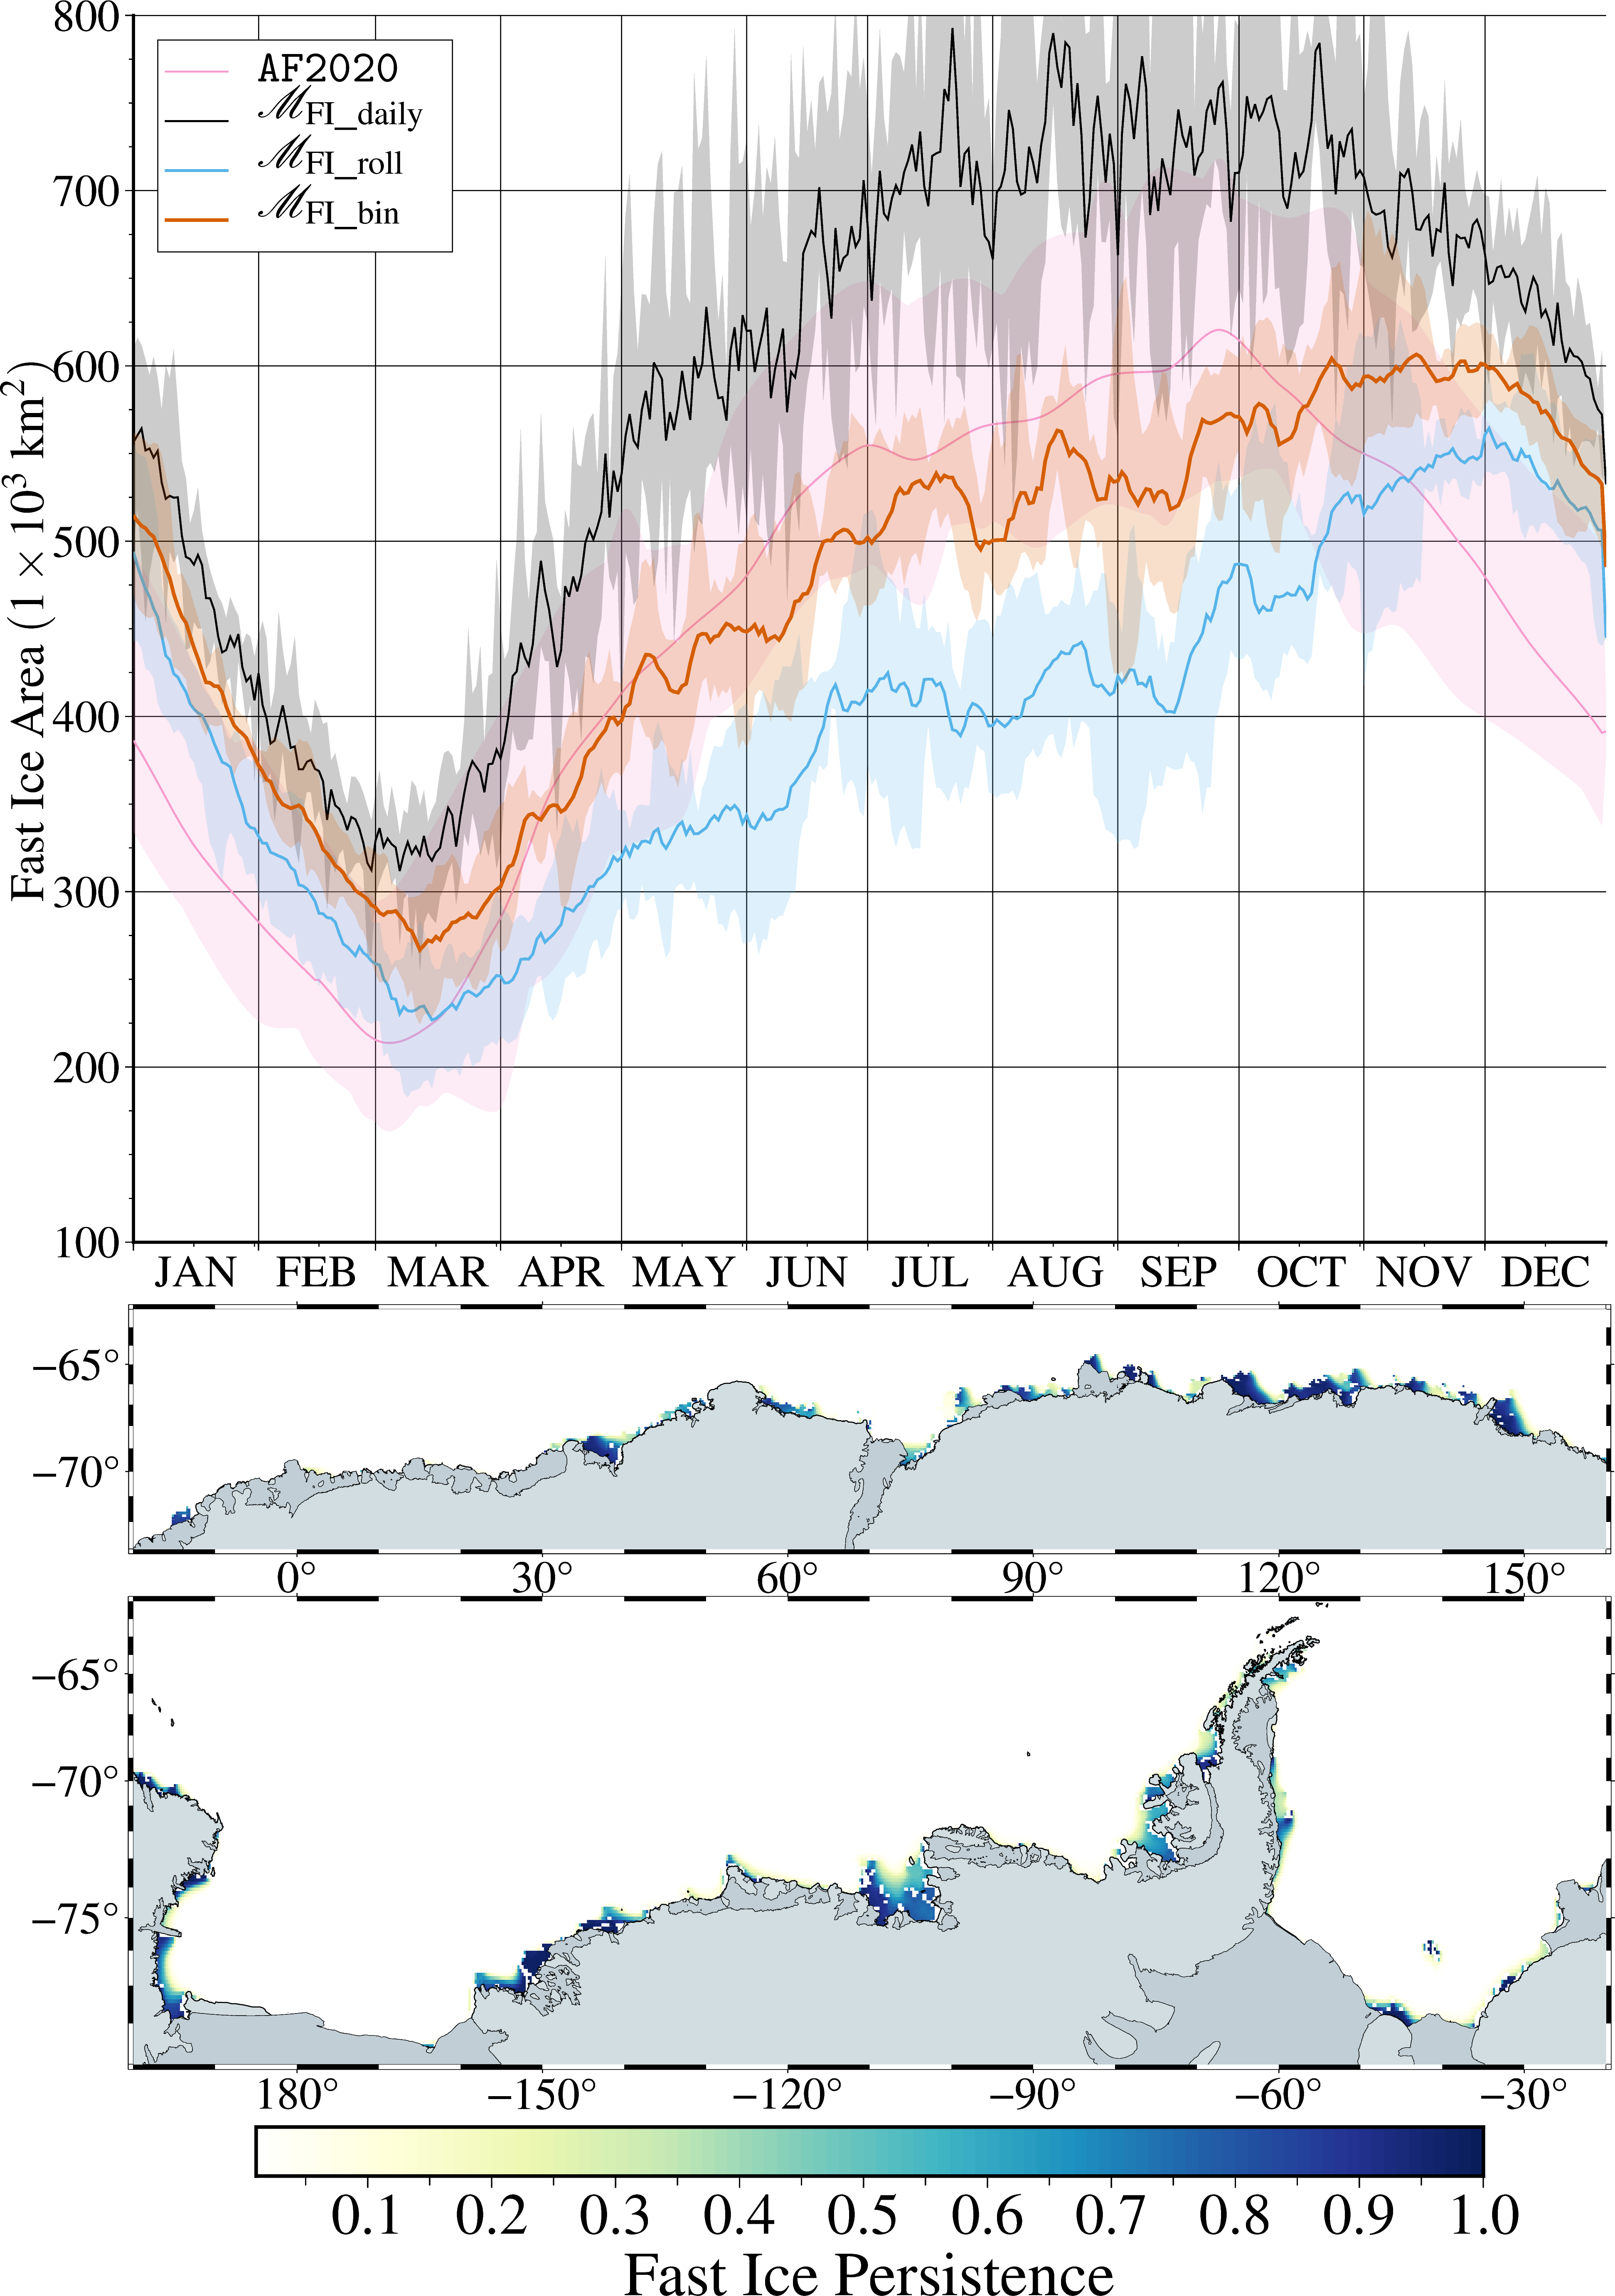

In [9]:
sim_name    = "elps-min"
dt0_str     = "1994-01-01"
dtN_str     = "1999-12-31"
P_log       = Path(Path.home(), "logs", "paper1_sandbox2.log")
SI_tool_mgr = SeaIceToolboxManager(P_log=P_log)
skip_names  = {"pack_ice.zarr","ice_diag_summary.csv","CMEMS-ORAS","AOM2-ERA5","AFIM_archive_status.json"}
for item in [sim_name]:#Path(SI_tools.D_dict["AFIM_out"]).iterdir():
    # if item.name in skip_names:
    #     continue
    sim_name = item#.name
    SI_tools = SI_tool_mgr.get_toolbox(dt0_str  = dt0_str,
                                       dtN_str  = dtN_str,
                                       sim_name = sim_name)
    SI_tools.pygmt_fastice_panel(fast_ice_variable = "FIA",   
                                 ice_class         = "FI_BT", 
                                 class_type        = "bin",   
                                 sim_name          = sim_name,
                                 ylim              = [100,800],
                                 water_clr         = "#DCF8FA",
                                 font_annot_pri    = "26p,Times-Roman",
                                 font_lab          = "28p,Times-Bold",
                                 overwrite_fig     = True,
                                 show_fig          = True)

In [ ]:
    # SI_tools.pygmt_fastice_panel(fast_ice_variable = "FIT",   
    #                              ice_class         = "FI_BT", 
    #                              class_type        = "bin",   
    #                              sim_name          = sim_name,
    #                              font_annot_pri    = "26p,Times-Roman",
    #                              font_lab          = "28p,Times-Bold",
    #                              overwrite_fig     = True,
    #                              show_fig          = False)
    # SI_tools.pygmt_fastice_panel(fast_ice_variable = "FIS",   
    #                              ice_class         = "FI_BT", 
    #                              class_type        = "bin",   
    #                              sim_name          = sim_name,
    #                              font_annot_pri    = "26p,Times-Roman",
    #                              font_lab          = "28p,Times-Bold",
    #                              overwrite_fig     = True,
    #                              show_fig          = False)
    # SI_tools.pygmt_fastice_panel(fast_ice_variable = "FIMAR",   
    #                              ice_class         = "FI_BT", 
    #                              class_type        = "bin",   
    #                              sim_name          = sim_name,
    #                              font_annot_pri    = "26p,Times-Roman",
    #                              font_lab          = "28p,Times-Bold",
    #                              water_clr         = "#F4A582",
    #                              overwrite_fig     = True,
    #                              show_fig          = False)
    # SI_tools.pygmt_fastice_panel(fast_ice_variable = "FIMVR",   
    #                              ice_class         = "FI_BT", 
    #                              class_type        = "bin",   
    #                              sim_name          = sim_name,
    #                              font_annot_pri    = "26p,Times-Roman",
    #                              font_lab          = "28p,Times-Bold",
    #                              water_clr         = "#F4A582",
    #                              overwrite_fig     = True,
    #                              show_fig          = False)
    # SI_tools.pygmt_fastice_panel(fast_ice_variable = "FITAR",   
    #                              ice_class         = "FI_BT", 
    #                              class_type        = "bin",   
    #                              sim_name          = sim_name,
    #                              font_annot_pri    = "26p,Times-Roman",
    #                              font_lab          = "28p,Times-Bold",
    #                              water_clr         = "#F4A582",
    #                              overwrite_fig     = True,
    #                              show_fig          = False)
    # SI_tools.pygmt_fastice_panel(fast_ice_variable = "FITVR",   
    #                              ice_class         = "FI_BT", 
    #                              class_type        = "bin",   
    #                              sim_name          = sim_name,
    #                              font_annot_pri    = "26p,Times-Roman",
    #                              font_lab          = "28p,Times-Bold",
    #                              water_clr         = "#F4A582",
    #                              overwrite_fig     = True,
    #                              show_fig          = False)

# Sensitivity of Fast Ice Area

In [35]:
sim_name    = "__dummy__"
dt0_str     = "1994-01-01"
dtN_str     = "1999-12-31"
P_log       = Path(Path.home(), "logs", "paper1_sandbox2.log")
SI_tool_mgr = SeaIceToolboxManager(P_log=P_log)
sim_names   = ["Cstar-max","gi-mid","Cstar-min"]
comp_name   = "Cstar-comparison"
# "FI-heavy"         : ["elps-min","FI-heavy"]
# "GI-perturbation"  : ["gi-mid","gi-mid-gi1","gi-mid-gi2","gi-mid-gi3"]
# "GI-comparison"    : ["gi-max","gi-mid","gi-min","gi-nil","gi-nil-def","notensnogi"]
# "Cstar-comparison" : "@[\\texttt{gi-mid}\\ \\mathrm{C}^{\\ast}=20@["
# "Pstar-comparison" : "@[\\texttt{gi-mid}\\ \\mathrm{P}^{\\ast}=2.75\\times10^4@["
# "ktens-comparison" : "@[\\texttt{gi-mid}\\ k_{T}=0.2@[", ["ktens-ext","ktens-max","gi-mid","ktens-min","ktens-nil"]
# "ktens-comparison" : "@[\\texttt{gi-mid}\\ \\mathrm{e}=2.0@[", ["elps-max","gi-mid","elps-mid","elps-min","elps-ext"]
FIA_dict    = {}
FIT_dict    = {}
#FITVR_dict  = {}
#FITAR_dict  = {}
#FIMAR_dict  = {}
for sim_name in sim_names:
    SI_tools = SI_tool_mgr.get_toolbox(sim_name = sim_name, dt0_str=dt0_str, dtN_str=dtN_str)
    FIA_dict['AF2020']  = {'FIA' : SI_tools.load_AF2020_FIA_summary()['FIA_obs']}
    P_zarr = Path(SI_tools.D_ispd_thresh, "FI_BT_bin_mets.zarr")
    SI_tools.logger.info(f"opening zarr met file: {P_zarr}")
    ds                   = xr.open_zarr(P_zarr, consolidated=False)
    FIA_dict[sim_name]   = {'FIA'   : ds['FIA']}
    FIT_dict[sim_name]   = {'FIT'   : ds['FIT']}
    #FITVR_dict[sim_name] = {'FITVR' : ds['FITVR']}
    #FITAR_dict[sim_name] = {'FITAR' : ds['FITAR']}
    #FIMAR_dict[sim_name] = {'FIMAR' : ds['FIMAR']}

2025-10-02 09:19:54,979 - INFO - log file connected: /home/581/da1339/logs/paper1_sandbox2.log
2025-10-02 09:19:55,017 - INFO - Dask Client Connected
  Dashboard      : /proxy/8787/status
  Threads        : 4
  Threads/Worker : [1, 1, 1, 1]
  Total Memory   : 64.00 GB

2025-10-02 09:19:55,018 - INFO - hemisphere initialised: SH
2025-10-02 09:19:55,020 - INFO - reading /g/data/gv90/da1339/afim_output/Cstar-max/ice_diag.d to construct /g/data/gv90/da1339/afim_output/Cstar-max/ice_in_AFIM_subset_Cstar-max.json
2025-10-02 09:19:55,022 - INFO -  self.ice_class defined as FI_BT
2025-10-02 09:19:55,023 - INFO - --- SeaIceToolbox Summary ---
2025-10-02 09:19:55,025 - INFO - Simulation Name     : Cstar-max
2025-10-02 09:19:55,026 - INFO - Analysis Start Date : 1994-01-01
2025-10-02 09:19:55,027 - INFO - Analysis End Date   : 1999-12-31
2025-10-02 09:19:55,028 - INFO - Speed Threshold     : 5.0e-04 m/s
2025-10-02 09:19:55,029 - INFO - Speed Type(s)       : BT
2025-10-02 09:19:55,030 - INFO - Ice

2025-10-02 09:20:05,780 - INFO - Cstar-max simulation will be included in extract_min_max_dates()
2025-10-02 09:20:05,785 - INFO - gi-mid simulation will be included in extract_min_max_dates()
2025-10-02 09:20:05,787 - INFO - Cstar-min simulation will be included in extract_min_max_dates()
2025-10-02 09:20:06,109 - INFO - pulling out data array for AF2020 and putting into dataframe
2025-10-02 09:20:06,111 - INFO - legend label: @[\texttt{AF2020}@[
2025-10-02 09:20:06,112 - INFO - line color  : black
2025-10-02 09:20:06,186 - INFO - pulling out data array for Cstar-max and putting into dataframe
2025-10-02 09:20:06,187 - INFO - legend label: @[\texttt{cstar-max}\ \mathrm{C}^{\ast}=30@[
2025-10-02 09:20:06,189 - INFO - line color  : #D55E00
2025-10-02 09:20:06,329 - INFO - pulling out data array for gi-mid and putting into dataframe
2025-10-02 09:20:06,330 - INFO - legend label: @[\texttt{gi-mid}\ \mathrm{C}^{\ast}=20@[
2025-10-02 09:20:06,331 - INFO - line color  : #56B4E9
2025-10-02 09

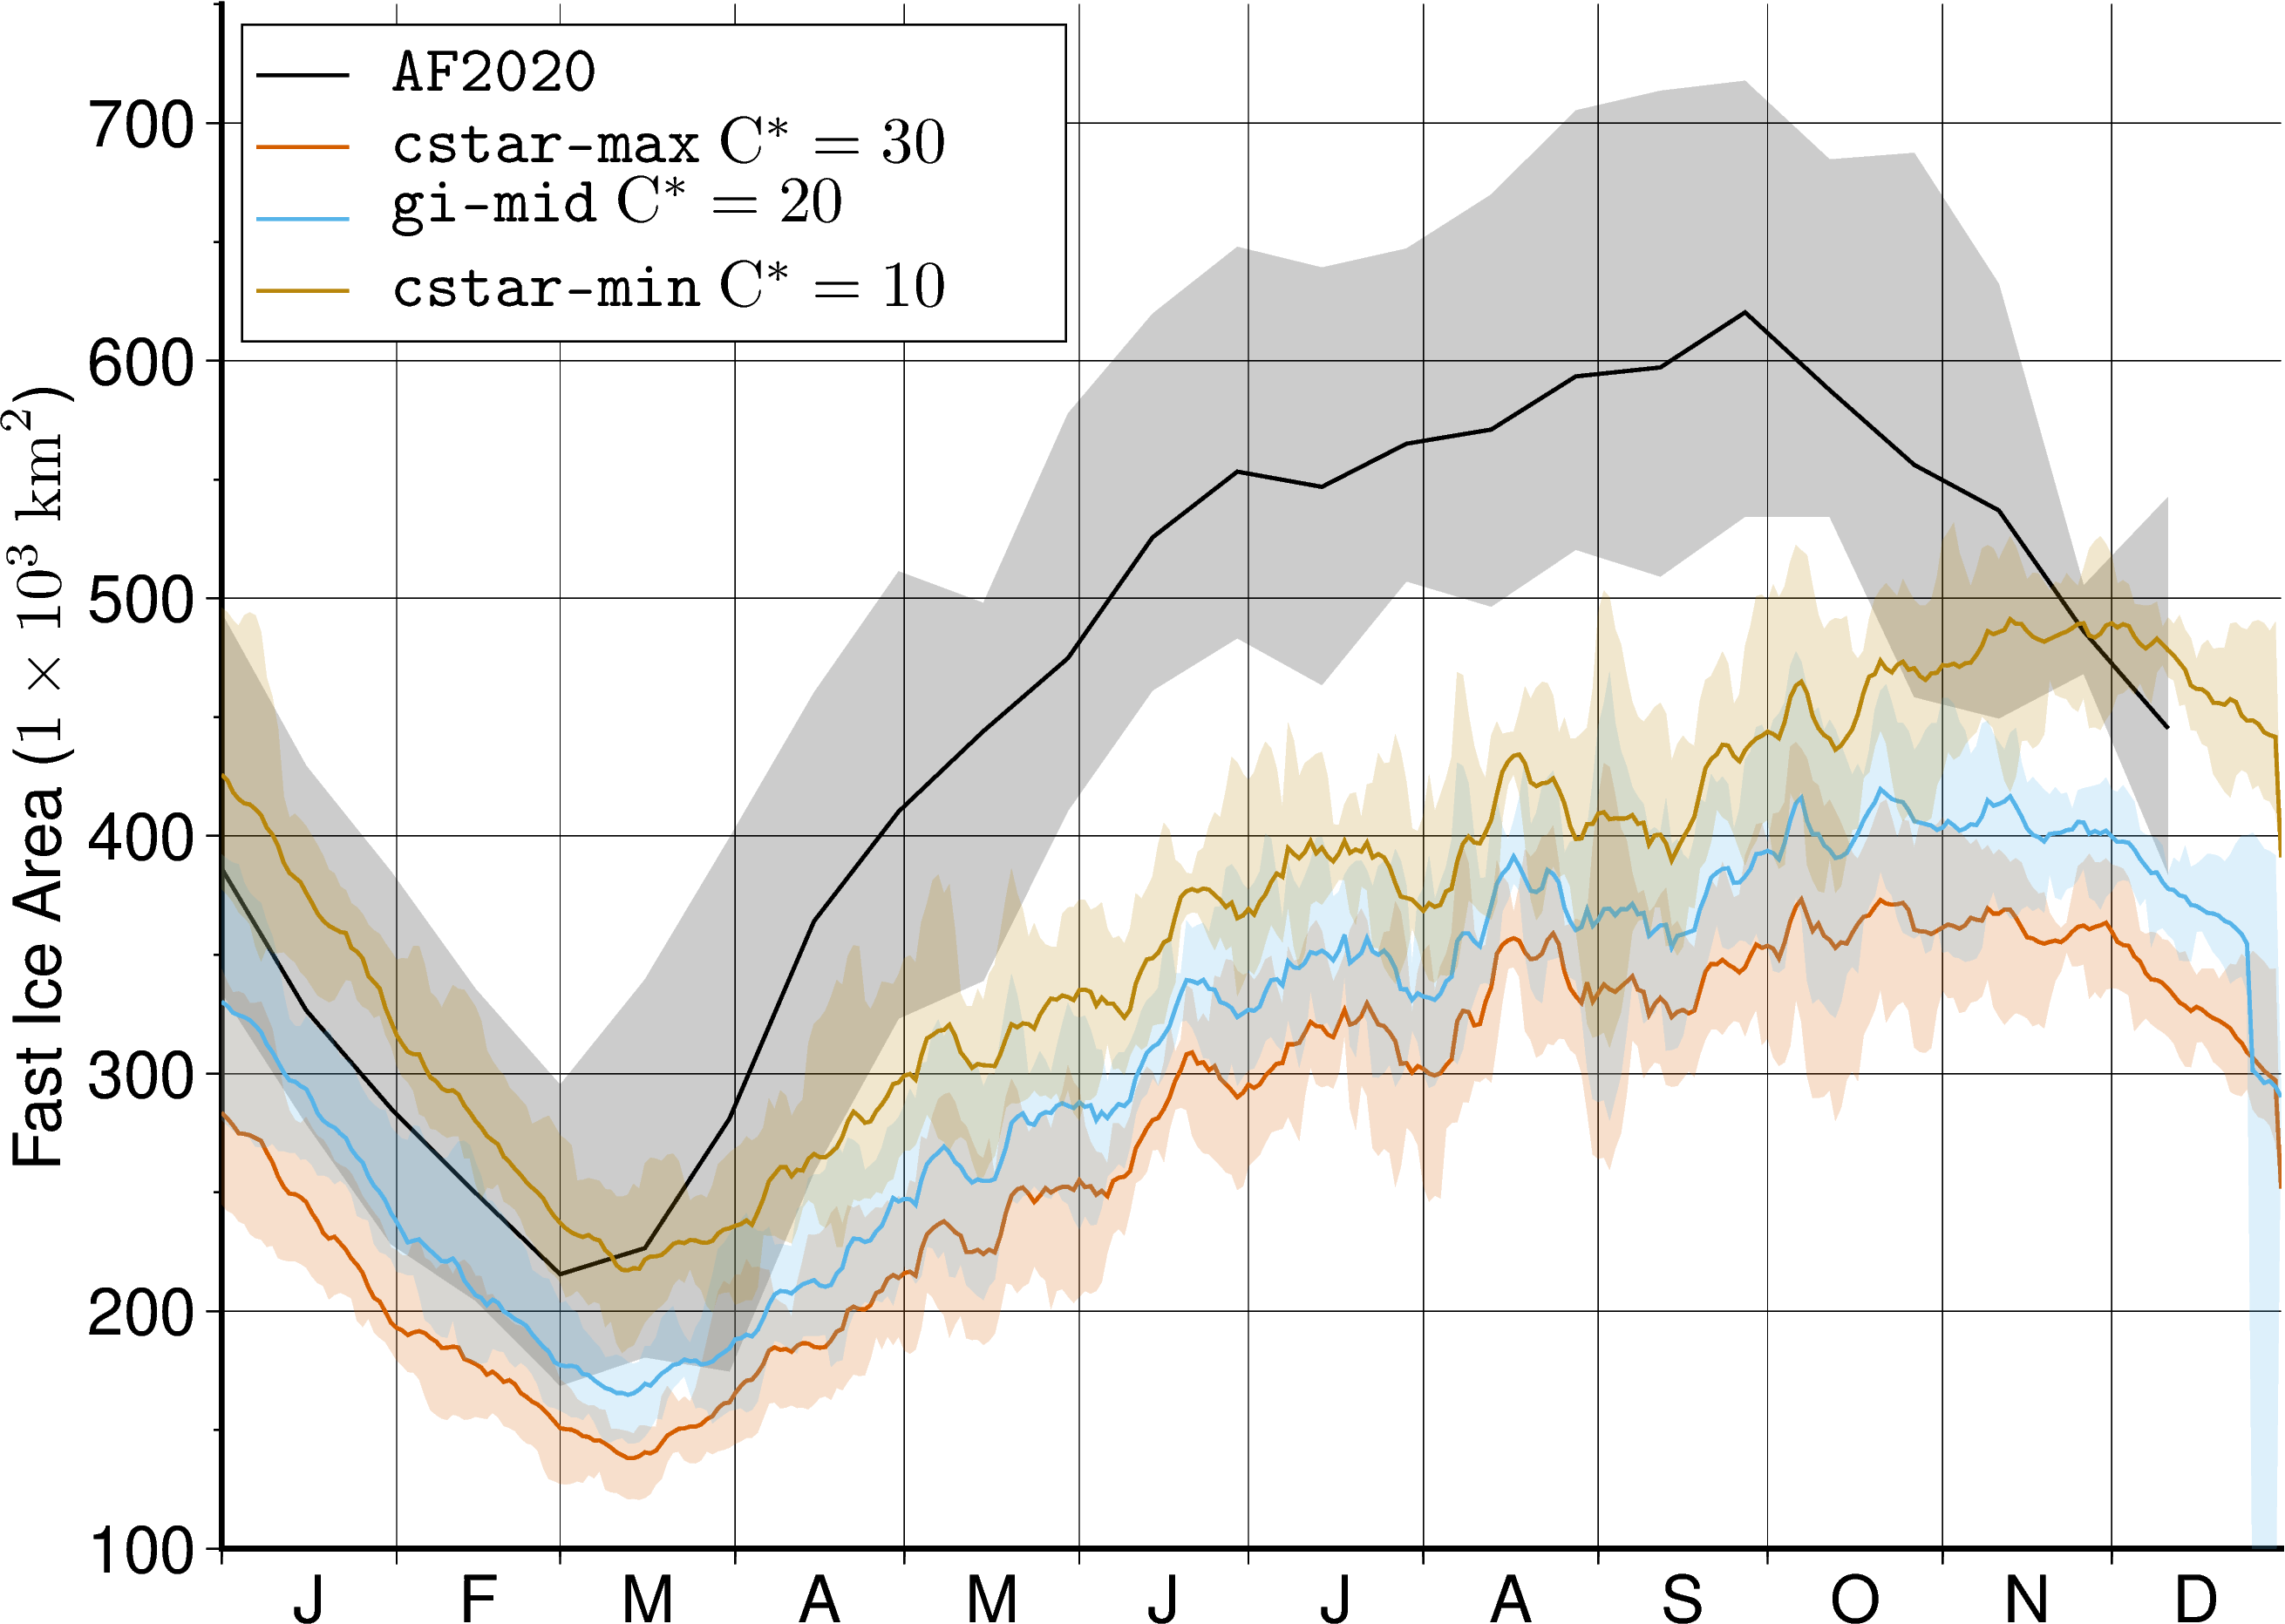

2025-10-02 09:20:09,103 - INFO - Cstar-max simulation will be included in extract_min_max_dates()
2025-10-02 09:20:09,106 - INFO - gi-mid simulation will be included in extract_min_max_dates()
2025-10-02 09:20:09,107 - INFO - Cstar-min simulation will be included in extract_min_max_dates()
2025-10-02 09:20:09,382 - INFO - pulling out data array for Cstar-max and putting into dataframe
2025-10-02 09:20:09,384 - INFO - legend label: @[\texttt{cstar-max}\ \mathrm{C}^{\ast}=30@[
2025-10-02 09:20:09,385 - INFO - line color  : #D55E00
2025-10-02 09:20:09,544 - INFO - pulling out data array for gi-mid and putting into dataframe
2025-10-02 09:20:09,545 - INFO - legend label: @[\texttt{gi-mid}\ \mathrm{C}^{\ast}=20@[
2025-10-02 09:20:09,547 - INFO - line color  : #56B4E9
2025-10-02 09:20:09,667 - INFO - pulling out data array for Cstar-min and putting into dataframe
2025-10-02 09:20:09,668 - INFO - legend label: @[\texttt{cstar-min}\ \mathrm{C}^{\ast}=10@[
2025-10-02 09:20:09,669 - INFO - line 

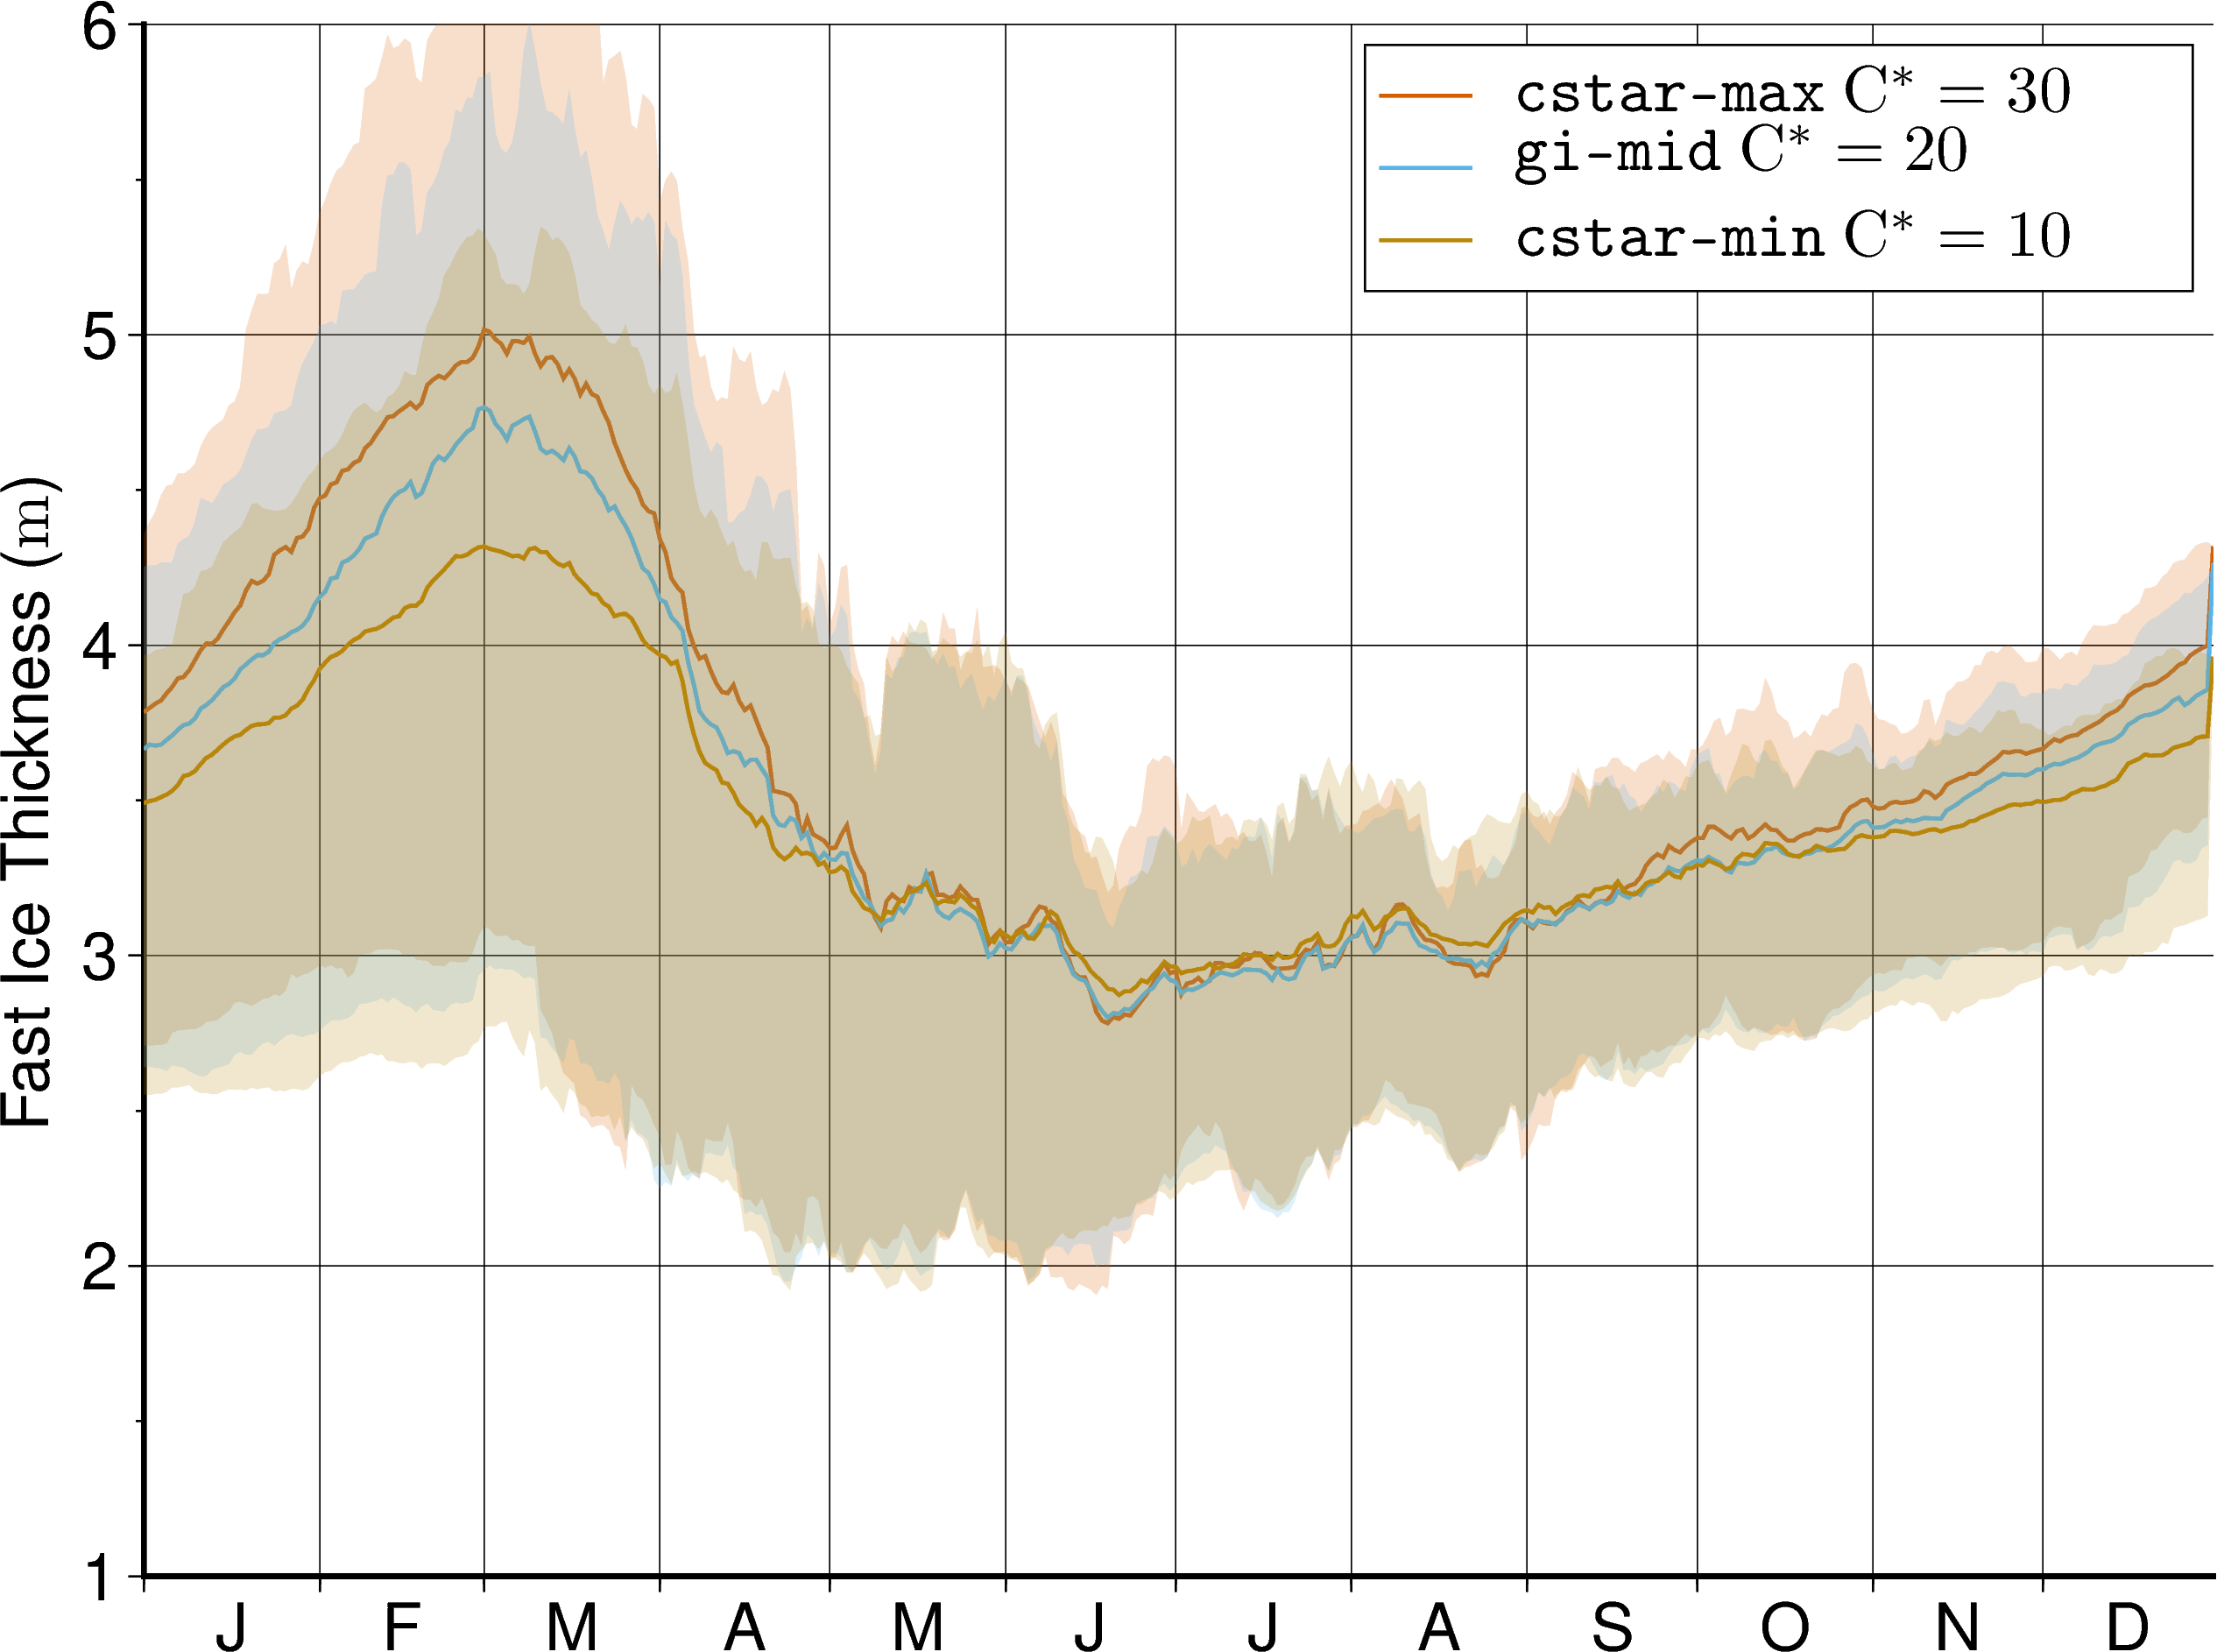

In [36]:
SI_tools.pygmt_timeseries(FIA_dict,
                          comp_name   = comp_name,
                          primary_key = "FIA",
                          climatology = True,
                          ylabel      = "Fast Ice Area (@[1\\times10^3\\ \\mathrm{km}^2@[)",
                          ylim        = [100,750],
                          show_fig    = True, 
                          legend_pos  = "JTL+jTL+o0.2c+w8c")
SI_tools.pygmt_timeseries(FIT_dict, 
                          comp_name   = comp_name,
                          primary_key = "FIT",
                          climatology = True,
                          ylabel      = "Fast Ice Thickness (@[\\mathrm{m}@[)",
                          ylim        = [1,6],
                          ytick_pri   = 1,
                          ytick_sec   = 0.5,
                          show_fig    = True, 
                          legend_pos  = "JTR+jTR+o0.2c+w8c")

In [ ]:
# SI_tools.pygmt_timeseries(FITVR_dict, 
#                           comp_name   = comp_name,
#                           primary_key = "FITVR",
#                           climatology = True,
#                           clim_smooth = 15, 
#                           ylabel      = "Fast Ice Thermodynamic Volume Rate (@[\\mathrm{m}/\\mathrm{s}@[)",
#                           ylim        = [-4,4],
#                           ytick_pri   = 1,
#                           ytick_sec   = 0.5,
#                           show_fig    = True, 
#                           legend_pos  = "JBC+jBC+o0.2c+w7c")
# SI_tools.pygmt_timeseries(FITAR_dict, 
#                           comp_name   = comp_name,
#                           primary_key = "FITAR",
#                           climatology = True,
#                           clim_smooth = 15,
#                           ylabel      = "Fast Ice Thermodynamic Area Rate (@[\\mathrm{m}/\\mathrm{s}@[)",
#                           ylim        = [-1,1],
#                           ytick_pri   = 1,
#                           ytick_sec   = 0.5,
#                           show_fig    = True, 
#                           legend_pos  = "JBC+jBC+o0.2c+w7c")
# SI_tools.pygmt_timeseries(FIMAR_dict, 
#                           comp_name   = comp_name,
#                           primary_key = "FIMAR",
#                           climatology = True,
#                           ylabel      = "Fast Ice Mechanical Area Rate (@[\\mathrm{m}/\\mathrm{s}@[)",
#                           ylim        = [-1,1],
#                           ytick_pri   = 1,
#                           ytick_sec   = 0.5,
#                           show_fig    = True, 
#                           legend_pos  = "JTC+jTC+o0.2c+w13c")

# ICE SPEED BIASES

created by running script: reG_OSISAF_ispd.py

In [ ]:
def load_ispd_diffs(sim_name):
    D_search = Path(Path.home(), "seaice", "OSI_SAF", "ice_drift_455m")
    F_search = "ispd_diffs_pygmt_nn_{sim}_199*.nc".format(sim=sim_name)
    P_       = sorted(D_search.rglob(F_search))
    return xr.open_mfdataset(P_, combine="by_coords")

ISP_bias               = {}
ISP_rmse               = {}
ISP_ang                = {}
ISP_cos                = {}
ds                     = load_ispd_diffs("elps-min")
ISP_bias['elps-min']   = {'ispd_bias'  : ds['d_ispd_CICE'].mean(dim=['ny','nx']).compute()}
ISP_rmse['elps-min']   = {'ispd_rmse'  : ds['RMSE_CICE']}
ISP_ang['elps-min']    = {'ang_bias'   : ds['ANG_CICE_mean']}
ISP_cos['elps-min']    = {'cos_bias'   : ds['COS_CICE_mean']}
ISP_bias['AOM2-ERA5']  = {'ispd_bias'  : ds['d_ispd_AOM2'].mean(dim=['ny','nx']).compute()}
ISP_rmse['AOM2-ERA5']  = {'ispd_rmse'  : ds['RMSE_AOM2']}
ISP_ang['AOM2-ERA5']   = {'ang_bias'   : ds['ANG_AOM2_mean']}
ISP_cos['AOM2-ERA5']   = {'cos_bias'   : ds['COS_AOM2_mean']}
ISP_bias['ORAS']       = {'ispd_bias'  : ds['d_ispd_ORAS'].mean(dim=['ny','nx']).compute()}
ISP_rmse['ORAS']       = {'ispd_rmse'  : ds['RMSE_ORAS']}
ISP_ang['ORAS']        = {'ang_bias'   : ds['ANG_ORAS_mean']}
ISP_cos['ORAS']        = {'cos_bias'   : ds['COS_ORAS_mean']}
ds                     = load_ispd_diffs("notensnogi")
ISP_bias['notensnogi'] = {'ispd_bias'  : ds['d_ispd_CICE'].mean(dim=['ny','nx']).compute()}
ISP_rmse['notensnogi'] = {'ispd_rmse'  : ds['RMSE_CICE']}
ISP_ang['notensnogi']  = {'ang_bias'   : ds['ANG_CICE_mean']}
ISP_cos['notensnogi']  = {'cos_bias'   : ds['COS_CICE_mean']}

sim_name    = "elps-min"
dt0_str     = "1994-01-01"
dtN_str     = "1999-12-31"
P_log       = Path(Path.home(), "logs", "paper1.log")
SI_tool_mgr = SeaIceToolboxManager(P_log=P_log)
sim_tools   = SI_tool_mgr.get_toolbox(sim_name, dt0_str=dt0_str, dtN_str=dtN_str)
sim_tools.pygmt_timeseries(ISP_bias,
                           comp_name    = "ISP_ispd_bias",
                           primary_key  = "ispd_bias",
                           climatology  = True,
                           clim_smooth  = 15,
                           ylabel       = "Sea Ice Speed Biases (m/s)",
                           ylim         = [-.1,.1],
                           ytick_pri    = .05,
                           ytick_sec    = .05,
                           legend_pos   = "JBL+jBL+o0.2c+w5c",
                           show_fig     = True)

# FAST ICE SENSITIVITY TABLE

In [26]:
ARCHIVE_DIR = Path.home() / "AFIM_archive"
dt0_str     = "1994-01-01"
dtN_str     = "1999-12-31"
P_log       = Path(Path.home(), "logs", f"paper1_sandbox_{datetime.now().strftime('%Y%m%d_%H%M%S')}.log")
# Metrics variable name mapping (left = what this script looks for, right = fallback names in your zarr)
VAR_CANDIDATES = {"bias":               ["bias", "fia_bias", "FIA_bias"],
                  "corr":               ["corr", "correlation", "pearson_r"],
                  "mae":                ["mae", "mean_abs_error"],
                  "rmse":               ["rmse", "root_mean_sq_error"],
                  "fipsi":              ["fipsi", "FIPSI", "persistence_stability_index"],
                  "fipmax":             ["fipmax", "FIP_max", "persistence_max_distance", "fip_max_km"],
                  "fia_max_area":       ["fia_max_area", "FIA_max_area", "fia_area_max", "fia_max_kkm2"],
                  "fia_min_area":       ["fia_min_area", "FIA_min_area", "fia_area_min", "fia_min_kkm2"],
                  "fia_max_onset_doy":  ["fia_max_onset_doy", "FIA_max_onset_doy", "onset_max_doy", "fia_onset_max"],
                  "fia_min_onset_doy":  ["fia_min_onset_doy", "FIA_min_onset_doy", "onset_min_doy", "fia_onset_min"],}
AREA_UNITS = "m2"  # one of {"kkm2", "km2", "m2"}
# Map archive folder names -> LaTeX \gls{} macros
GLOSS_MAP = {"elps-min":  r"\gls{elpsmin}",
             "elps-ext":  r"\gls{elpsext}",
             "elps-mid":  r"\gls{elpsmid}",
             "elps-max":  r"\gls{elpsmax}",
             "FI-heavy":  r"\gls{fiheavy}",
             "ry93":      r"\gls{ry}",
             "Pstar-max": r"\gls{pstarmax}",
             "Pstar-min": r"\gls{pstarmin}",
             "Cstar-max": r"\gls{cstarmax}",
             "Cstar-min": r"\gls{cstarmin}",
             "gi-max":    r"\gls{gimax}",
             "gi-mid":    r"\gls{gimid}",
             "gi-min":    r"\gls{gimin}",
             "gi-nil":    r"\gls{ginil}",
             "gi-nil-def":r"\gls{ginildef}",
             "notensnogi":r"\gls{nofi}",
             "ktens-max": r"\gls{ktensmax}",
             "ktens-min": r"\gls{ktensmin}",
             "ktens-nil": r"\gls{ktensnil}",
             "ktens-ext": r"\gls{ktensext}"}
# Preferred row order (match paper)
PREFERRED_ORDER = ["elps-min","elps-ext","elps-mid","elps-max","FI-heavy","ry93",
                   "Pstar-max","Pstar-min","Cstar-min","Cstar-max",
                   "gi-max","gi-mid","gi-min","gi-nil","gi-nil-def","notensnogi",
                   "ktens-max","ktens-min","ktens-nil","ktens-ext"]

def _get_scalar(ds: xr.Dataset, keys: list[str], default=np.nan):
    """Return a Python float from ds[key], trying keys in order; supports DataArray or 0-d variable."""
    for k in keys:
        if k in ds:
            v = ds[k]
            try:
                # xr.DataArray(…)-> .item(); if it has dims, reduce if size==1
                return float(v.item() if v.size == 1 else v.values.squeeze().item())
            except Exception:
                pass
    return float(default)
    
def _area_to_kkm2(val: float) -> float:
    if np.isnan(val):
        return np.nan
    if AREA_UNITS == "kkm2":  # already in 1e3 km^2
        return float(val)
    if AREA_UNITS == "km2":
        return float(val) / 1e3
    if AREA_UNITS == "m2":
        return float(val) / 1e9  # m^2 -> (1e3 km^2)
    return float(val)

import pandas as pd
import math

def _latex_escape(s: str) -> str:
    """Escape minimal LaTeX specials in text fields."""
    if s is None:
        return ""
    rep = {
        "\\": r"\textbackslash{}",
        "&": r"\&",
        "%": r"\%",
        "$": r"\$",
        "#": r"\#",
        "_": r"\_",
        "{": r"\{",
        "}": r"\}",
        "~": r"\textasciitilde{}",
        "^": r"\textasciicircum{}",
    }
    out = str(s)
    for k, v in rep.items():
        out = out.replace(k, v)
    return out

def format_table_latex(
    df: pd.DataFrame,
    max_width="\\linewidth",
    label="tab:FIA_skill_metrics_ext",
    caption=None
) -> str:
    """
    Build a LaTeX tabular string with a units row, using booktabs + adjustbox.
    Requires in preamble:
        \\usepackage{booktabs}
        \\usepackage{siunitx}
        \\usepackage{adjustbox}
    """
    # Column order & pretty headers
    cols    = [
        "Experiment", "bias", "corr", "mae", "rmse", "fipsi", "fipmax",
        "fia_max_area", "fia_min_area", "fia_max_onset_doy", "fia_min_onset_doy"
    ]
    units   = [
        "",
        "", "", "", "", "",  # bias, corr, mae, rmse, fipsi
        r"\si{\kilo\metre}", r"$1\times10^3\ \mathrm{km}^2$", r"$1\times10^3\ \mathrm{km}^2$",
        r"\text{onset (DOY)}", r"\text{onset (DOY)}"
    ]
    headers = [
        r"\textbf{Experiment}",
        r"\textbf{\gls{bias}}",
        r"\textbf{\gls{corr}}",
        r"\textbf{\gls{mae}}",
        r"\textbf{\gls{rmse}}",
        r"\textbf{\gls{fipsi}}",
        r"\textbf{\gls{fipmax}}",
        r"\textbf{\gls{fia}$_\mathrm{max}$}",
        r"\textbf{\gls{fia}$_\mathrm{min}$}",
        r"\textbf{\gls{fia}$_\mathrm{max}$}",
        r"\textbf{\gls{fia}$_\mathrm{min}$}",
    ]

    # Alignment: 1 'l' + 10 'r'
    align = "l" + "r"*10

    # Ensure required columns exist
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise KeyError(f"Missing columns in df: {missing}")

    # Format numbers per your style
    def f1(x): return "" if (x is None or (isinstance(x,float) and math.isnan(x))) else f"{x:.1f}"
    def f3(x): return "" if (x is None or (isinstance(x,float) and math.isnan(x))) else f"{x:.3f}"

    df_fmt = df.copy()
    df_fmt["Experiment"]        = df_fmt["Experiment"].map(_latex_escape)
    df_fmt["bias"]              = df_fmt["bias"].map(f1)
    df_fmt["corr"]              = df_fmt["corr"].map(f3)
    df_fmt["mae"]               = df_fmt["mae"].map(f1)
    df_fmt["rmse"]              = df_fmt["rmse"].map(f1)
    df_fmt["fipsi"]             = df_fmt["fipsi"].map(f3)
    df_fmt["fipmax"]            = df_fmt["fipmax"].map(f1)
    df_fmt["fia_max_area"]      = df_fmt["fia_max_area"].map(f1)
    df_fmt["fia_min_area"]      = df_fmt["fia_min_area"].map(f1)
    df_fmt["fia_max_onset_doy"] = df_fmt["fia_max_onset_doy"].map(f1)
    df_fmt["fia_min_onset_doy"] = df_fmt["fia_min_onset_doy"].map(f1)

    # Build LaTeX lines
    header_line = " & ".join(headers) + r" \\"
    units_line  = " & ".join(units)   + r" \\"

    rows = []
    for _, row in df_fmt[cols].iterrows():
        rows.append(" & ".join(str(v) for v in row.values) + r" \\")
    body = "\n".join(rows)

    # Wrap with table environment if caption/label provided
    top = ""
    bottom = ""
    if caption or label:
        cap = f"\\caption{{{caption}}}\n" if caption else ""
        lab = f"\\label{{{label}}}\n"    if label   else ""
        top = "\\begin{table}[t]\n" + cap + lab
        bottom = "\\end{table}"

    # IMPORTANT: double braces for literal braces in an f-string
    latex = fr"""{top}\begin{{adjustbox}}{{max width={max_width}}}
\begin{{tabular}}{{{align}}}
\toprule
{header_line}
{units_line}
\midrule
{body}
\bottomrule
\end{{tabular}}
\end{{adjustbox}}
{bottom}"""
    return latex


In [27]:
SI_tool_mgr = SeaIceToolboxManager(P_log=P_log)
SI_tools = SI_tool_mgr.get_toolbox(dt0_str="1994-01-01", dtN_str="1999-12-31", sim_name="elps-min")
FI_bin = SI_tools.load_classified_ice(ice_type="FI")

2025-10-03 19:18:57,358 - INFO - log file connected: /home/581/da1339/logs/paper1_sandbox_20251003_191856.log
2025-10-03 19:18:57,368 - INFO - Dask Client Connected
  Dashboard      : /proxy/34537/status
  Threads        : 4
  Threads/Worker : [1, 1, 1, 1]
  Total Memory   : 64.00 GB

2025-10-03 19:18:57,369 - INFO - hemisphere initialised: SH
2025-10-03 19:18:57,371 - INFO - reading /g/data/gv90/da1339/afim_output/elps-min/ice_diag.d to construct /g/data/gv90/da1339/afim_output/elps-min/ice_in_AFIM_subset_elps-min.json
2025-10-03 19:18:57,403 - INFO -  self.ice_class defined as FI_BT
2025-10-03 19:18:57,404 - INFO - --- SeaIceToolbox Summary ---
2025-10-03 19:18:57,405 - INFO - Simulation Name     : elps-min
2025-10-03 19:18:57,406 - INFO - Analysis Start Date : 1994-01-01
2025-10-03 19:18:57,408 - INFO - Analysis End Date   : 1999-12-31
2025-10-03 19:18:57,409 - INFO - Speed Threshold     : 5.0e-04 m/s
2025-10-03 19:18:57,410 - INFO - Speed Type(s)       : BT
2025-10-03 19:18:57,411 

In [28]:
# Discover simulation names (folders) and exclude non-runs
EXCLUDE   = {"AOM2-ERA5"}  # add "*.json", "*.csv" are excluded automatically below
sim_names = sorted([p.name for p in ARCHIVE_DIR.iterdir() if p.is_dir() and (p.name not in EXCLUDE) and not p.name.endswith(".zarr")])
# Instantiate the toolbox manager (creates a toolbox per sim inside the loop)
SI_tool_mgr = SeaIceToolboxManager(P_log=P_log)
rows        = []
skipped     = []
for sim_name in sim_names:
    # Build toolbox for this sim & window
    SI_tools = SI_tool_mgr.get_toolbox(dt0_str=dt0_str, dtN_str=dtN_str, sim_name=sim_name)
    # Load the precomputed metrics Zarr (defaults are fine unless you need specific grid/type)
    ds_mets = SI_tools.load_computed_metrics(ice_type="FI_BT")
    # Extract scalars (robust to different var names)
    bias              = ds_mets["Bias"].values
    corr              = ds_mets["Corr"].values
    mae               = ds_mets["MAE"].values
    rmse              = ds_mets["RMSE"].values
    print(ds_mets)
    fipsi             = ds_mets["persistence_stability_index"].values
    fipmax            = ds_mets["persistence_max_distance"].values
    fia_max_area      = _area_to_kkm2(_get_scalar(ds_mets, VAR_CANDIDATES["fia_max_area"]))
    fia_min_area      = _area_to_kkm2(_get_scalar(ds_mets, VAR_CANDIDATES["fia_min_area"]))
    fia_max_onset_doy = _get_scalar(ds_mets, VAR_CANDIDATES["fia_max_onset_doy"])
    fia_min_onset_doy = _get_scalar(ds_mets, VAR_CANDIDATES["fia_min_onset_doy"])
    # Experiment label as \gls macro if we know it; else raw folder name
    exp_label = GLOSS_MAP.get(sim_name, sim_name)
    rows.append({"Experiment"        : exp_label,
                 "sim_name"          : sim_name,  # keep raw for ordering/sorting
                 "bias"              : bias,
                 "corr"              : corr,
                 "mae"               : mae,
                 "rmse"              : rmse,
                 "fipsi"             : fipsi,
                 "fipmax"            : fipmax,
                 "fia_max_area"      : fia_max_area,
                 "fia_min_area"      : fia_min_area,
                 "fia_max_onset_doy" : fia_max_onset_doy,
                 "fia_min_onset_doy" : fia_min_onset_doy})
df = pd.DataFrame(rows)

2025-10-03 19:18:58,998 - INFO - log file connected: /home/581/da1339/logs/paper1_sandbox_20251003_191856.log
2025-10-03 19:18:59,005 - INFO - Dask Client Connected
  Dashboard      : /proxy/34537/status
  Threads        : 4
  Threads/Worker : [1, 1, 1, 1]
  Total Memory   : 64.00 GB

2025-10-03 19:18:59,006 - INFO - hemisphere initialised: SH
2025-10-03 19:18:59,008 - INFO - reading /g/data/gv90/da1339/afim_output/Cstar-max/ice_diag.d to construct /g/data/gv90/da1339/afim_output/Cstar-max/ice_in_AFIM_subset_Cstar-max.json
2025-10-03 19:18:59,011 - INFO -  self.ice_class defined as FI_BT
2025-10-03 19:18:59,012 - INFO - --- SeaIceToolbox Summary ---
2025-10-03 19:18:59,013 - INFO - Simulation Name     : Cstar-max
2025-10-03 19:18:59,015 - INFO - Analysis Start Date : 1994-01-01
2025-10-03 19:18:59,016 - INFO - Analysis End Date   : 1999-12-31
2025-10-03 19:18:59,017 - INFO - Speed Threshold     : 5.0e-04 m/s
2025-10-03 19:18:59,018 - INFO - Speed Type(s)       : BT
2025-10-03 19:18:59,

<xarray.Dataset> Size: 53MB
Dimensions:                      (time: 2191, nj: 540, ni: 1440)
Coordinates:
    TLAT                         (nj, ni) float32 3MB ...
    TLON                         (nj, ni) float32 3MB ...
    ULAT                         (nj, ni) float32 3MB ...
    ULON                         (nj, ni) float32 3MB ...
    lat                          (nj, ni) float64 6MB ...
    lon                          (nj, ni) float64 6MB ...
  * time                         (time) datetime64[ns] 18kB 1994-01-01 ... 19...
Dimensions without coordinates: nj, ni
Data variables: (12/46)
    Bias                         float32 4B -175.9
    Corr                         float32 4B 0.89
    FIA                          (time) float32 9kB ...
    FIA_DOY Max Mean             float64 8B ...
    FIA_DOY Max Std              float64 8B ...
    FIA_DOY Min Mean             float64 8B ...
    ...                           ...
    SD_Obs                       float32 4B ...
    area_ever_wi

2025-10-03 19:18:59,286 - INFO - Simulation Name     : Pstar-max
2025-10-03 19:18:59,287 - INFO - Analysis Start Date : 1994-01-01
2025-10-03 19:18:59,289 - INFO - Analysis End Date   : 1999-12-31
2025-10-03 19:18:59,290 - INFO - Speed Threshold     : 5.0e-04 m/s
2025-10-03 19:18:59,291 - INFO - Speed Type(s)       : BT
2025-10-03 19:18:59,291 - INFO - Ice Type(s)         : FI
2025-10-03 19:18:59,292 - INFO - Mean Period         : 15 days
2025-10-03 19:18:59,293 - INFO - Binary-days Window  : 11 days
2025-10-03 19:18:59,294 - INFO - Binary-days Min-Days: 9
2025-10-03 19:18:59,295 - INFO - Using GI?           : True
2025-10-03 19:18:59,296 - INFO - Overwrite Zarr      : False
2025-10-03 19:18:59,297 - INFO - Save Figures        : True
2025-10-03 19:18:59,298 - INFO - Show Figures        : False
2025-10-03 19:18:59,299 - INFO - Hemisphere          : south
2025-10-03 19:18:59,299 - INFO - ------------------------------
2025-10-03 19:18:59,363 - INFO - log file connected: /home/581/da1339/

<xarray.Dataset> Size: 53MB
Dimensions:                      (time: 2191, nj: 540, ni: 1440)
Coordinates:
    TLAT                         (nj, ni) float32 3MB ...
    TLON                         (nj, ni) float32 3MB ...
    ULAT                         (nj, ni) float32 3MB ...
    ULON                         (nj, ni) float32 3MB ...
    lat                          (nj, ni) float64 6MB ...
    lon                          (nj, ni) float64 6MB ...
  * time                         (time) datetime64[ns] 18kB 1994-01-01 ... 19...
Dimensions without coordinates: nj, ni
Data variables: (12/46)
    Bias                         float32 4B -95.18
    Corr                         float32 4B 0.9176
    FIA                          (time) float32 9kB ...
    FIA_DOY Max Mean             float64 8B ...
    FIA_DOY Max Std              float64 8B ...
    FIA_DOY Min Mean             float64 8B ...
    ...                           ...
    SD_Obs                       float32 4B ...
    area_ever_

2025-10-03 19:18:59,555 - INFO - Mean Period         : 15 days
2025-10-03 19:18:59,557 - INFO - Binary-days Window  : 11 days
2025-10-03 19:18:59,558 - INFO - Binary-days Min-Days: 9
2025-10-03 19:18:59,559 - INFO - Using GI?           : True
2025-10-03 19:18:59,560 - INFO - Overwrite Zarr      : False
2025-10-03 19:18:59,561 - INFO - Save Figures        : True
2025-10-03 19:18:59,562 - INFO - Show Figures        : False
2025-10-03 19:18:59,563 - INFO - Hemisphere          : south
2025-10-03 19:18:59,564 - INFO - ------------------------------
2025-10-03 19:18:59,626 - INFO - log file connected: /home/581/da1339/logs/paper1_sandbox_20251003_191856.log
2025-10-03 19:18:59,635 - INFO - Dask Client Connected
  Dashboard      : /proxy/34537/status
  Threads        : 4
  Threads/Worker : [1, 1, 1, 1]
  Total Memory   : 64.00 GB

2025-10-03 19:18:59,636 - INFO - hemisphere initialised: SH
2025-10-03 19:18:59,638 - INFO - reading /g/data/gv90/da1339/afim_output/elps-mid/ice_diag.d to construc

<xarray.Dataset> Size: 53MB
Dimensions:                      (time: 2191, nj: 540, ni: 1440)
Coordinates:
    TLAT                         (nj, ni) float32 3MB ...
    TLON                         (nj, ni) float32 3MB ...
    ULAT                         (nj, ni) float32 3MB ...
    ULON                         (nj, ni) float32 3MB ...
    lat                          (nj, ni) float64 6MB ...
    lon                          (nj, ni) float64 6MB ...
  * time                         (time) datetime64[ns] 18kB 1994-01-01 ... 19...
Dimensions without coordinates: nj, ni
Data variables: (12/46)
    Bias                         float32 4B -197.3
    Corr                         float32 4B 0.8593
    FIA                          (time) float32 9kB ...
    FIA_DOY Max Mean             float64 8B ...
    FIA_DOY Max Std              float64 8B ...
    FIA_DOY Min Mean             float64 8B ...
    ...                           ...
    SD_Obs                       float32 4B ...
    area_ever_

2025-10-03 19:18:59,819 - INFO - --- SeaIceToolbox Summary ---
2025-10-03 19:18:59,820 - INFO - Simulation Name     : gi-max
2025-10-03 19:18:59,822 - INFO - Analysis Start Date : 1994-01-01
2025-10-03 19:18:59,823 - INFO - Analysis End Date   : 1999-12-31
2025-10-03 19:18:59,824 - INFO - Speed Threshold     : 5.0e-04 m/s
2025-10-03 19:18:59,825 - INFO - Speed Type(s)       : BT
2025-10-03 19:18:59,826 - INFO - Ice Type(s)         : FI
2025-10-03 19:18:59,828 - INFO - Mean Period         : 15 days
2025-10-03 19:18:59,829 - INFO - Binary-days Window  : 11 days
2025-10-03 19:18:59,831 - INFO - Binary-days Min-Days: 9
2025-10-03 19:18:59,832 - INFO - Using GI?           : True
2025-10-03 19:18:59,833 - INFO - Overwrite Zarr      : False
2025-10-03 19:18:59,834 - INFO - Save Figures        : True
2025-10-03 19:18:59,835 - INFO - Show Figures        : False
2025-10-03 19:18:59,836 - INFO - Hemisphere          : south
2025-10-03 19:18:59,837 - INFO - ------------------------------
2025-10-03

<xarray.Dataset> Size: 53MB
Dimensions:                      (time: 2191, nj: 540, ni: 1440)
Coordinates:
    TLAT                         (nj, ni) float32 3MB ...
    TLON                         (nj, ni) float32 3MB ...
    ULAT                         (nj, ni) float32 3MB ...
    ULON                         (nj, ni) float32 3MB ...
    lat                          (nj, ni) float64 6MB ...
    lon                          (nj, ni) float64 6MB ...
  * time                         (time) datetime64[ns] 18kB 1994-01-01 ... 19...
Dimensions without coordinates: nj, ni
Data variables: (12/46)
    Bias                         float32 4B -10.0
    Corr                         float32 4B 0.8619
    FIA                          (time) float32 9kB ...
    FIA_DOY Max Mean             float64 8B ...
    FIA_DOY Max Std              float64 8B ...
    FIA_DOY Min Mean             float64 8B ...
    ...                           ...
    SD_Obs                       float32 4B ...
    area_ever_w

2025-10-03 19:19:00,082 - INFO -  self.ice_class defined as FI_BT
2025-10-03 19:19:00,084 - INFO - --- SeaIceToolbox Summary ---
2025-10-03 19:19:00,085 - INFO - Simulation Name     : gi-mid-gi2
2025-10-03 19:19:00,086 - INFO - Analysis Start Date : 1994-01-01
2025-10-03 19:19:00,087 - INFO - Analysis End Date   : 1999-12-31
2025-10-03 19:19:00,088 - INFO - Speed Threshold     : 5.0e-04 m/s
2025-10-03 19:19:00,089 - INFO - Speed Type(s)       : BT
2025-10-03 19:19:00,090 - INFO - Ice Type(s)         : FI
2025-10-03 19:19:00,091 - INFO - Mean Period         : 15 days
2025-10-03 19:19:00,092 - INFO - Binary-days Window  : 11 days
2025-10-03 19:19:00,094 - INFO - Binary-days Min-Days: 9
2025-10-03 19:19:00,095 - INFO - Using GI?           : True
2025-10-03 19:19:00,096 - INFO - Overwrite Zarr      : False
2025-10-03 19:19:00,097 - INFO - Save Figures        : True
2025-10-03 19:19:00,099 - INFO - Show Figures        : False
2025-10-03 19:19:00,100 - INFO - Hemisphere          : south
2025

<xarray.Dataset> Size: 53MB
Dimensions:                      (time: 2191, nj: 540, ni: 1440)
Coordinates:
    TLAT                         (nj, ni) float32 3MB ...
    TLON                         (nj, ni) float32 3MB ...
    ULAT                         (nj, ni) float32 3MB ...
    ULON                         (nj, ni) float32 3MB ...
    lat                          (nj, ni) float64 6MB ...
    lon                          (nj, ni) float64 6MB ...
  * time                         (time) datetime64[ns] 18kB 1994-01-01 ... 19...
Dimensions without coordinates: nj, ni
Data variables: (12/46)
    Bias                         float32 4B -148.7
    Corr                         float32 4B 0.8095
    FIA                          (time) float32 9kB ...
    FIA_DOY Max Mean             float64 8B ...
    FIA_DOY Max Std              float64 8B ...
    FIA_DOY Min Mean             float64 8B ...
    ...                           ...
    SD_Obs                       float32 4B ...
    area_ever_

2025-10-03 19:19:00,343 - INFO - Mean Period         : 15 days
2025-10-03 19:19:00,344 - INFO - Binary-days Window  : 11 days
2025-10-03 19:19:00,346 - INFO - Binary-days Min-Days: 9
2025-10-03 19:19:00,348 - INFO - Using GI?           : False
2025-10-03 19:19:00,349 - INFO - Overwrite Zarr      : False
2025-10-03 19:19:00,351 - INFO - Save Figures        : True
2025-10-03 19:19:00,352 - INFO - Show Figures        : False
2025-10-03 19:19:00,352 - INFO - Hemisphere          : south
2025-10-03 19:19:00,353 - INFO - ------------------------------
2025-10-03 19:19:00,406 - INFO - log file connected: /home/581/da1339/logs/paper1_sandbox_20251003_191856.log
2025-10-03 19:19:00,414 - INFO - Dask Client Connected
  Dashboard      : /proxy/34537/status
  Threads        : 4
  Threads/Worker : [1, 1, 1, 1]
  Total Memory   : 64.00 GB

2025-10-03 19:19:00,415 - INFO - hemisphere initialised: SH
2025-10-03 19:19:00,417 - INFO - reading /g/data/gv90/da1339/afim_output/gi-nil-def/ice_diag.d to const

<xarray.Dataset> Size: 53MB
Dimensions:                      (time: 2191, nj: 540, ni: 1440)
Coordinates:
    TLAT                         (nj, ni) float32 3MB ...
    TLON                         (nj, ni) float32 3MB ...
    ULAT                         (nj, ni) float32 3MB ...
    ULON                         (nj, ni) float32 3MB ...
    lat                          (nj, ni) float64 6MB ...
    lon                          (nj, ni) float64 6MB ...
  * time                         (time) datetime64[ns] 18kB 1994-01-01 ... 19...
Dimensions without coordinates: nj, ni
Data variables: (12/46)
    Bias                         float32 4B -231.8
    Corr                         float32 4B 0.6561
    FIA                          (time) float32 9kB ...
    FIA_DOY Max Mean             float64 8B ...
    FIA_DOY Max Std              float64 8B ...
    FIA_DOY Min Mean             float64 8B ...
    ...                           ...
    SD_Obs                       float32 4B ...
    area_ever_

2025-10-03 19:19:00,599 - INFO - --- SeaIceToolbox Summary ---
2025-10-03 19:19:00,600 - INFO - Simulation Name     : ktens-max
2025-10-03 19:19:00,602 - INFO - Analysis Start Date : 1994-01-01
2025-10-03 19:19:00,603 - INFO - Analysis End Date   : 1999-12-31
2025-10-03 19:19:00,604 - INFO - Speed Threshold     : 5.0e-04 m/s
2025-10-03 19:19:00,605 - INFO - Speed Type(s)       : BT
2025-10-03 19:19:00,606 - INFO - Ice Type(s)         : FI
2025-10-03 19:19:00,607 - INFO - Mean Period         : 15 days
2025-10-03 19:19:00,608 - INFO - Binary-days Window  : 11 days
2025-10-03 19:19:00,609 - INFO - Binary-days Min-Days: 9
2025-10-03 19:19:00,610 - INFO - Using GI?           : True
2025-10-03 19:19:00,611 - INFO - Overwrite Zarr      : False
2025-10-03 19:19:00,612 - INFO - Save Figures        : True
2025-10-03 19:19:00,613 - INFO - Show Figures        : False
2025-10-03 19:19:00,614 - INFO - Hemisphere          : south
2025-10-03 19:19:00,615 - INFO - ------------------------------
2025-10

<xarray.Dataset> Size: 53MB
Dimensions:                      (time: 2191, nj: 540, ni: 1440)
Coordinates:
    TLAT                         (nj, ni) float32 3MB ...
    TLON                         (nj, ni) float32 3MB ...
    ULAT                         (nj, ni) float32 3MB ...
    ULON                         (nj, ni) float32 3MB ...
    lat                          (nj, ni) float64 6MB ...
    lon                          (nj, ni) float64 6MB ...
  * time                         (time) datetime64[ns] 18kB 1994-01-01 ... 19...
Dimensions without coordinates: nj, ni
Data variables: (12/46)
    Bias                         float32 4B -65.35
    Corr                         float32 4B 0.7761
    FIA                          (time) float32 9kB ...
    FIA_DOY Max Mean             float64 8B ...
    FIA_DOY Max Std              float64 8B ...
    FIA_DOY Min Mean             float64 8B ...
    ...                           ...
    SD_Obs                       float32 4B ...
    area_ever_

2025-10-03 19:19:00,860 - INFO - --- SeaIceToolbox Summary ---
2025-10-03 19:19:00,861 - INFO - Simulation Name     : ndte-max
2025-10-03 19:19:00,862 - INFO - Analysis Start Date : 1994-01-01
2025-10-03 19:19:00,863 - INFO - Analysis End Date   : 1999-12-31
2025-10-03 19:19:00,864 - INFO - Speed Threshold     : 5.0e-04 m/s
2025-10-03 19:19:00,865 - INFO - Speed Type(s)       : BT
2025-10-03 19:19:00,866 - INFO - Ice Type(s)         : FI
2025-10-03 19:19:00,866 - INFO - Mean Period         : 15 days
2025-10-03 19:19:00,868 - INFO - Binary-days Window  : 11 days
2025-10-03 19:19:00,869 - INFO - Binary-days Min-Days: 9
2025-10-03 19:19:00,870 - INFO - Using GI?           : True
2025-10-03 19:19:00,871 - INFO - Overwrite Zarr      : False
2025-10-03 19:19:00,872 - INFO - Save Figures        : True
2025-10-03 19:19:00,873 - INFO - Show Figures        : False
2025-10-03 19:19:00,874 - INFO - Hemisphere          : south
2025-10-03 19:19:00,875 - INFO - ------------------------------
2025-10-

<xarray.Dataset> Size: 53MB
Dimensions:                      (time: 2191, nj: 540, ni: 1440)
Coordinates:
    TLAT                         (nj, ni) float32 3MB ...
    TLON                         (nj, ni) float32 3MB ...
    ULAT                         (nj, ni) float32 3MB ...
    ULON                         (nj, ni) float32 3MB ...
    lat                          (nj, ni) float64 6MB ...
    lon                          (nj, ni) float64 6MB ...
  * time                         (time) datetime64[ns] 18kB 1994-01-01 ... 19...
Dimensions without coordinates: nj, ni
Data variables: (12/46)
    Bias                         float32 4B 26.85
    Corr                         float32 4B 0.8688
    FIA                          (time) float32 9kB ...
    FIA_DOY Max Mean             float64 8B ...
    FIA_DOY Max Std              float64 8B ...
    FIA_DOY Min Mean             float64 8B ...
    ...                           ...
    SD_Obs                       float32 4B ...
    area_ever_w

2025-10-03 19:19:01,117 - INFO - Speed Threshold     : 5.0e-04 m/s
2025-10-03 19:19:01,118 - INFO - Speed Type(s)       : BT
2025-10-03 19:19:01,119 - INFO - Ice Type(s)         : FI
2025-10-03 19:19:01,120 - INFO - Mean Period         : 15 days
2025-10-03 19:19:01,121 - INFO - Binary-days Window  : 11 days
2025-10-03 19:19:01,121 - INFO - Binary-days Min-Days: 9
2025-10-03 19:19:01,123 - INFO - Using GI?           : False
2025-10-03 19:19:01,124 - INFO - Overwrite Zarr      : False
2025-10-03 19:19:01,125 - INFO - Save Figures        : True
2025-10-03 19:19:01,126 - INFO - Show Figures        : False
2025-10-03 19:19:01,127 - INFO - Hemisphere          : south
2025-10-03 19:19:01,128 - INFO - ------------------------------
2025-10-03 19:19:01,181 - INFO - log file connected: /home/581/da1339/logs/paper1_sandbox_20251003_191856.log
2025-10-03 19:19:01,189 - INFO - Dask Client Connected
  Dashboard      : /proxy/34537/status
  Threads        : 4
  Threads/Worker : [1, 1, 1, 1]
  Total M

<xarray.Dataset> Size: 53MB
Dimensions:                      (time: 2191, nj: 540, ni: 1440)
Coordinates:
    TLAT                         (nj, ni) float32 3MB ...
    TLON                         (nj, ni) float32 3MB ...
    ULAT                         (nj, ni) float32 3MB ...
    ULON                         (nj, ni) float32 3MB ...
    lat                          (nj, ni) float64 6MB ...
    lon                          (nj, ni) float64 6MB ...
  * time                         (time) datetime64[ns] 18kB 1994-01-01 ... 19...
Dimensions without coordinates: nj, ni
Data variables: (12/46)
    Bias                         float32 4B -426.7
    Corr                         float32 4B 0.9323
    FIA                          (time) float32 9kB ...
    FIA_DOY Max Mean             float64 8B ...
    FIA_DOY Max Std              float64 8B ...
    FIA_DOY Min Mean             float64 8B ...
    ...                           ...
    SD_Obs                       float32 4B ...
    area_ever_

In [29]:
# Order rows to match your manuscript, with any extras appended alphabetically
order     = [s for s in PREFERRED_ORDER if s in df["sim_name"].values]
extras    = sorted(set(df["sim_name"].values) - set(order))
order_idx = order + extras
df        = df.set_index("sim_name").loc[order_idx].reset_index(drop=True)
# Reorder visible columns (drop sim_name)
df = df[["Experiment","bias","corr","mae","rmse","fipsi","fipmax","fia_max_area","fia_min_area","fia_max_onset_doy","fia_min_onset_doy"]]
# Show a quick preview
print(df)
latex_tabular = format_table_latex(df, max_width="\\linewidth", label="tab:FIA_skill_metrics_ext")
print(latex_tabular)
# save to tex file
OUT_TEX = Path.home() / "paper1_FIA_skill_metrics_table.tex"
OUT_TEX.write_text(latex_tabular)
print(OUT_TEX)

         Experiment        bias        corr                 mae  \
0     \gls{elpsmin}    20.41795  0.84908307  58.751434326171875   
1     \gls{elpsext}   71.541756  0.91170526   72.16920471191406   
2     \gls{elpsmid}   -69.77587   0.8370845    83.4891586303711   
3     \gls{elpsmax}  -197.29224    0.859317    197.292236328125   
4     \gls{fiheavy}   157.95804  0.77834547  157.95803833007812   
5          \gls{ry}   -239.8893   0.7060457  239.88929748535156   
6    \gls{pstarmax}   -95.17591  0.91759825   95.17591094970703   
7    \gls{pstarmin}  -229.19682   0.6248642   229.1968231201172   
8    \gls{cstarmin}   -82.38554  0.72937036   101.2900161743164   
9    \gls{cstarmax}   -175.8562  0.89001894    175.856201171875   
10      \gls{gimax}  -10.001062   0.8619092    67.2250747680664   
11      \gls{gimid}  -141.57361  0.86537826   141.5736083984375   
12      \gls{gimin}  -227.79462   0.7775309  227.79461669921875   
13      \gls{ginil}  -231.75964   0.6560695   231.759643554687

In [24]:
sim_name    = "Cstar-max"
ispd_thresh = 5.0e-4
dt0_str     = "1994-01-01"
dtN_str     = "1999-12-31"
load_vars = ['aice','tarea','hi','strength','dvidtt','daidtt','dvidtd','daidtd']
P_log     = Path(Path.home(), "logs", f"metrics_{sim_name}_ispd_thresh{ispd_thresh}.log")
SI_mgr    = SeaIceToolboxManager(P_log=P_log)
SI_tools  = SI_mgr.get_toolbox(sim_name             = sim_name,
                                   dt0_str              = dt0_str,
                                   dtN_str              = dtN_str,
                                   ice_speed_threshold  = ispd_thresh,
                                   overwrite_zarr       = True,
                                   overwrite_saved_figs = True)
# Load classified ice masks and data
FI_day  = SI_tools.load_classified_ice(bin_days=False)['FI_mask']
FI_bin  = SI_tools.load_classified_ice(bin_days=True)['FI_mask']
FI_rol  = SI_tools.load_classified_ice(bin_days=False, roll_mean=True)['FI_mask']
CICE_SO = SI_tools.load_cice_zarr(slice_hem=True, variables=load_vars)
A       = CICE_SO['tarea'].isel(time=0)
# Apply the mask to the data
FI_daily = CICE_SO.where(FI_day)
FI_rolly = CICE_SO.where(FI_rol)
FI_binly = CICE_SO.where(FI_bin)
# Create FI dictionaries for dy, rl, and bn
FI_dy = SI_tools.fast_ice_metrics_data_dict(FI_day, FI_daily, A)
FI_rl = SI_tools.fast_ice_metrics_data_dict(FI_rol, FI_rolly, A)
FI_bn = SI_tools.fast_ice_metrics_data_dict(FI_bin, FI_binly, A)
# Compute metrics for each FI type
FI_types = [('FI_BT', FI_dy), ('FI_BT_roll', FI_rl), ('FI_BT_bin', FI_bn)]

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34537 instead
  warnings.warn(
2025-10-03 17:33:13,315 - INFO - log file connected: /home/581/da1339/logs/metrics_Cstar-max_ispd_thresh0.0005.log
2025-10-03 17:33:13,322 - INFO - Dask Client Connected
  Dashboard      : /proxy/34537/status
  Threads        : 4
  Threads/Worker : [1, 1, 1, 1]
  Total Memory   : 64.00 GB

2025-10-03 17:33:13,324 - INFO - hemisphere initialised: SH
2025-10-03 17:33:13,325 - INFO - reading /g/data/gv90/da1339/afim_output/Cstar-max/ice_diag.d to construct /g/data/gv90/da1339/afim_output/Cstar-max/ice_in_AFIM_subset_Cstar-max.json
2025-10-03 17:33:13,329 - INFO -  self.ice_class defined as FI_BT
2025-10-03 17:33:13,330 - INFO - --- SeaIceToolbox Summary ---
2025-10-03 17:33:13,331 - INFO - Simulation Name     : Cstar-max
2025-10-03 17

In [25]:
for prefix, FI_data in FI_types:
    P_mets_zarr = Path(SI_tools.D_ispd_thresh, f"{prefix}_mets.zarr")
    SI_tools.compute_sea_ice_metrics(FI_data, 
                                     ice_type="FI",
                                     P_mets_zarr=P_mets_zarr,
                                     ice_area_scale=SI_tools.FIC_scale)

2025-10-03 17:33:33,174 - INFO - ¡¡¡ COMPUTING ICE METRICS for FI !!!
2025-10-03 17:33:33,177 - INFO - results will be written to /g/data/gv90/da1339/afim_output/Cstar-max/zarr/ispd_thresh_5.0e-4/FI_BT_mets.zarr
2025-10-03 17:33:33,179 - INFO - Computing Ice **AREA** for Hemisphere
2025-10-03 17:33:33,546 - INFO - GI-area_calc: grid (G_t) lon min: -180.0
2025-10-03 17:33:33,550 - INFO - GI-area_calc: grid (G_t) lon max: 179.99492982355082
2025-10-03 17:33:33,552 - INFO - GI-area_calc: grid (G_t) lat min: -81.0770008338366
2025-10-03 17:33:33,555 - INFO - GI-area_calc: grid (G_t) lat max: 89.94042815946277
2025-10-03 17:33:33,583 - INFO - Computing Ice **VOLUME** for Hemisphere
2025-10-03 17:33:33,951 - INFO - GI-area_calc: grid (G_t) lon min: -180.0
2025-10-03 17:33:33,953 - INFO - GI-area_calc: grid (G_t) lon max: 179.99492982355082
2025-10-03 17:33:33,958 - INFO - GI-area_calc: grid (G_t) lat min: -81.0770008338366
2025-10-03 17:33:33,960 - INFO - GI-area_calc: grid (G_t) lat max: 89